In [1]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import os
import datetime
from sklearn.utils.class_weight import compute_class_weight
import optuna
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc, roc_auc_score, precision_score, recall_score, precision_recall_curve

2026-01-16 15:04:23.475247: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-16 15:04:24.671975: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Проверка доступности GPU
print(f"Доступно GPU: {len(tf.config.list_physical_devices('GPU'))}")
print(f"Версия TensorFlow: {tf.__version__}")

# Принудительное использование GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Используется GPU: {gpus[0]}")
    except RuntimeError as e:
        print(f"Ошибка настройки GPU: {e}")
else:
    print("GPU не найдены, используется CPU")

# Добавь это ПЕРЕД созданием модели

Доступно GPU: 0
Версия TensorFlow: 2.16.1
GPU не найдены, используется CPU


2026-01-16 15:04:27.548907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2026-01-16 15:04:27.831836: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [3]:
# Базовый путь к папке с данными
base_path = '../Data/Binary_CNN_data/'

# Загружаем массивы из папки Binary_CNN_data
X_train_cnn = np.load(f'{base_path}X_train_cnn.npy')
X_val_cnn = np.load(f'{base_path}X_val_cnn.npy')
X_test_cnn = np.load(f'{base_path}X_test_cnn.npy')

y_train = np.load(f'{base_path}y_train.npy')
y_val = np.load(f'{base_path}y_val.npy')
y_test = np.load(f'{base_path}y_test.npy')

In [4]:
len(X_test_cnn)

612

In [5]:
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [6]:
X_train_cnn.shape[1:] 

(25, 16, 1)

Input shape: (25, 16, 1)

АНАЛИЗ БАЛАНСА КЛАССОВ
Тренировочная выборка: {0: 749, 1: 250}
Валидационная выборка: {0: 322, 1: 107}
Тестовая выборка: {0: 459, 1: 153}


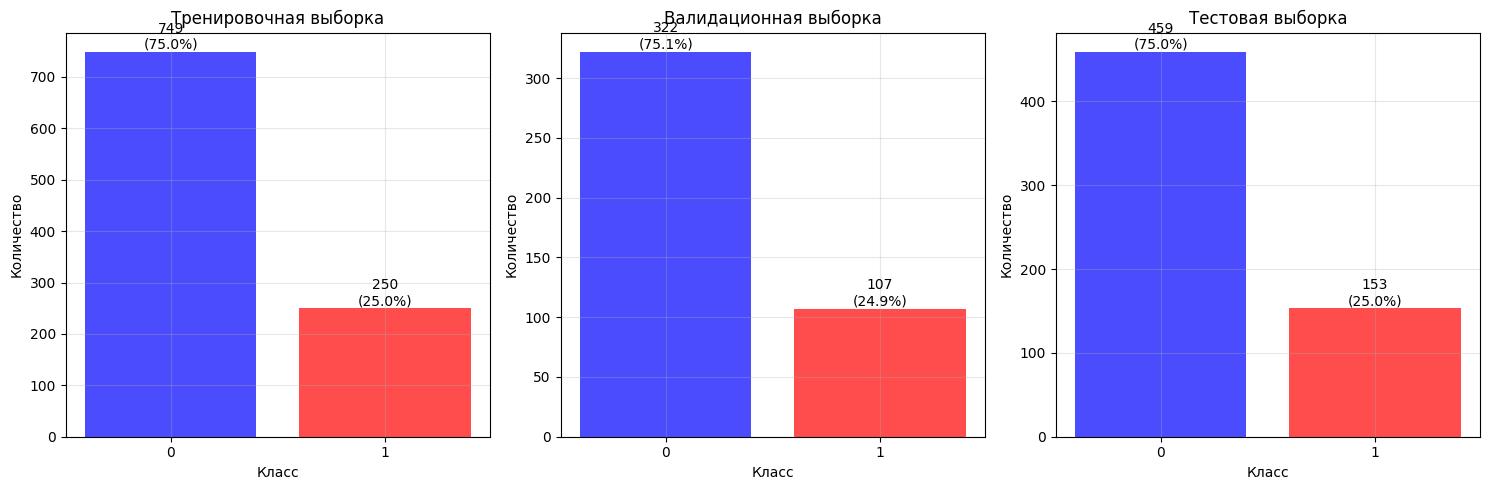


БАЛАНСИРОВКА КЛАССОВ
Веса классов: {0: 0.6668891855807744, 1: 1.998}

АРХИТЕКТУРА МОДЕЛИ


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "CNN_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25, 16, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ CNN_Feature_Extractor           │ (None, 5)              │        97,861 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Classifier_Head (Sequential)    │ (None, 1)              │           337 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 98,198 (383.59 KB)

 Trainable params: 97,702 (381.65 KB)

 Non-trainable params: 496 (1.94 KB)


НАЧАЛО ОБУЧЕНИЯ С БАЛАНСИРОВКОЙ КЛАССОВ
Epoch 1/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5558 - f1_score: 0.4101 - loss: 0.7305 - precision: 0.3013 - recall: 0.6497
Epoch 1: val_f1_score improved from None to 0.43231, saving model to ../Debugging_Information/Bests_Models/1_binary_classification_best_model.keras

Epoch 1: finished saving model to ../Debugging_Information/Bests_Models/1_binary_classification_best_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.5576 - f1_score: 0.4215 - loss: 0.7407 - precision: 0.3132 - recall: 0.6440 - val_accuracy: 0.3939 - val_f1_score: 0.4323 - val_loss: 0.7171 - val_precision: 0.2821 - val_recall: 0.9252 - learning_rate: 0.0010
Epoch 2/50
30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5624 - f1_score: 0.3706 - loss: 0.7534 - precision: 0.2822 - recall: 0.5425
Epoch 2: val_f1_score did not improve from 0.43231
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5576 - f1_score: 0.3962 - loss: 0.7403 - preci

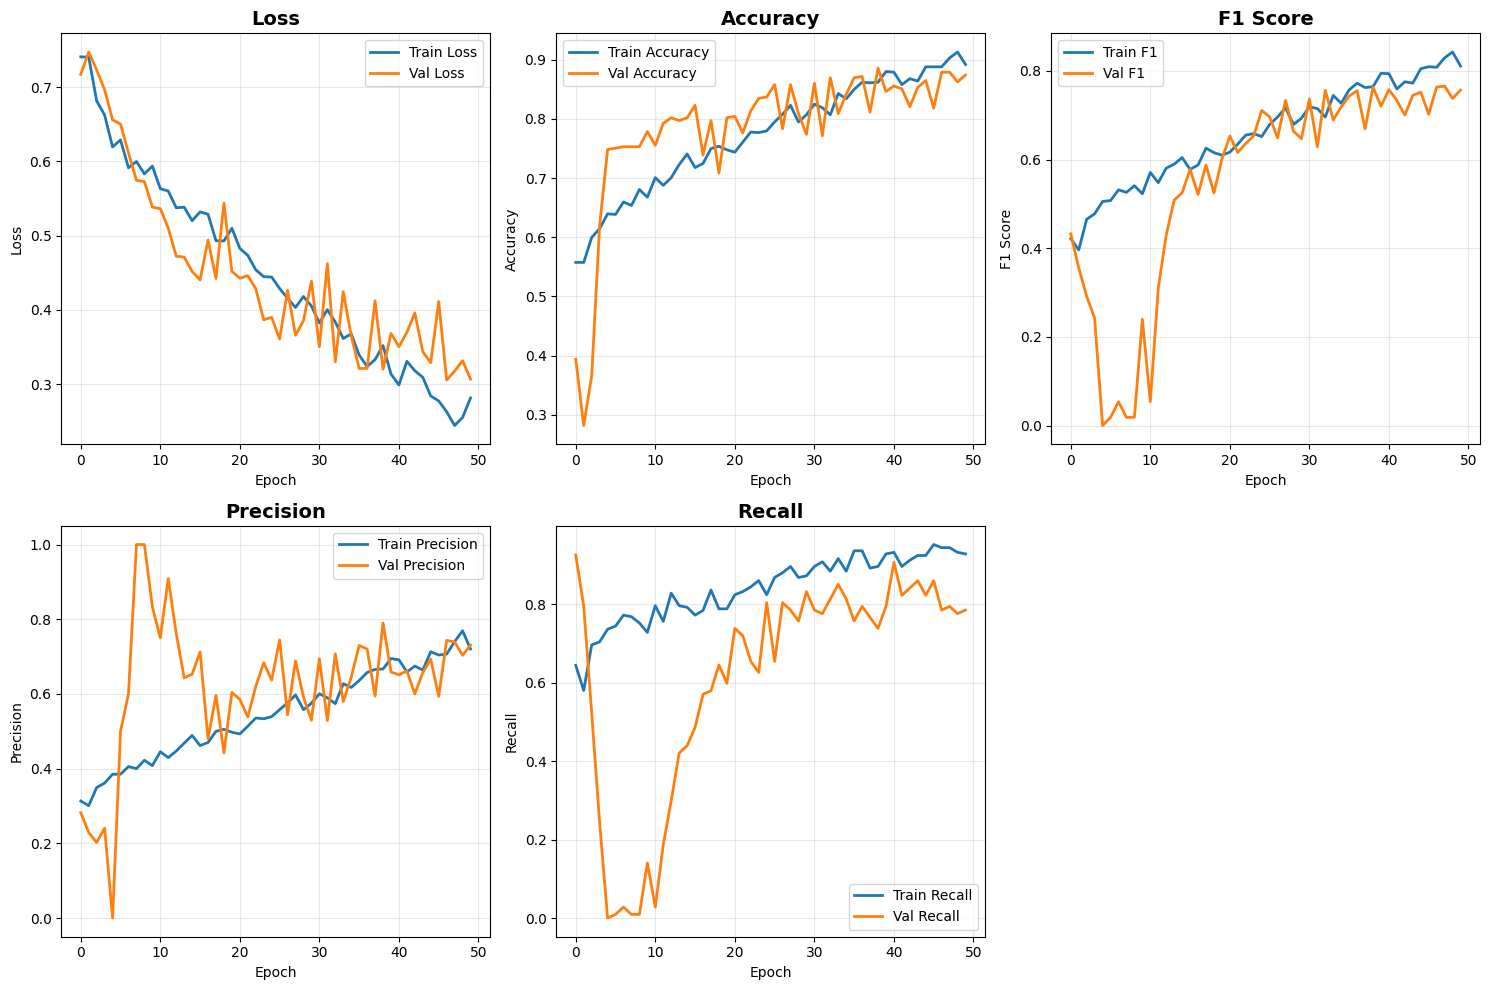


ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ
Test Loss: 0.2749
Test Accuracy: 0.9003
Test Precision: 0.7840
Test Recall: 0.8301
Test F1 Score: 0.8063

ПОИСК ОПТИМАЛЬНОГО ПОРОГА КЛАССИФИКАЦИИ
Стандартный порог (0.5):
  F1: 0.8063, Precision: 0.7840, Recall: 0.8301

Оптимальный порог: 0.790
  F1: 0.8198, Precision: 0.8923, Recall: 0.7582
Улучшение F1: 0.0134


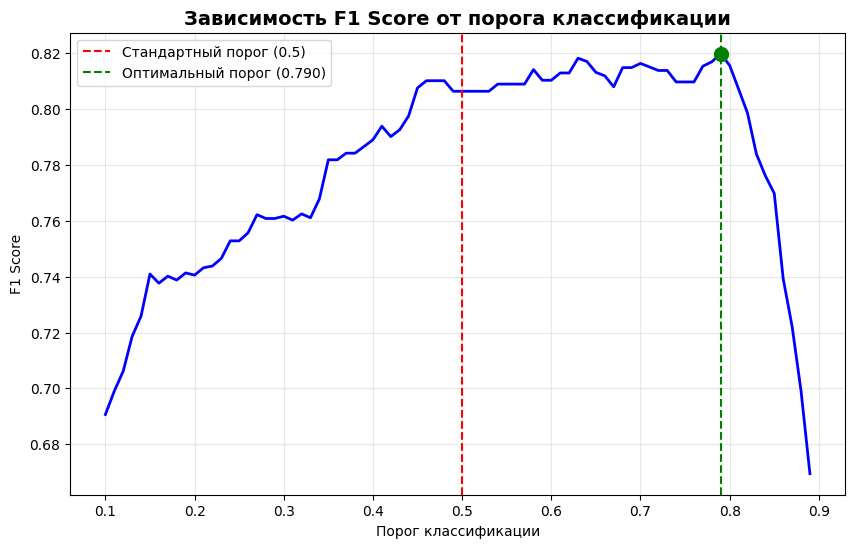


ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ (порог = 0.790)
              precision    recall  f1-score   support

     Class 0     0.9232    0.9695    0.9458       459
     Class 1     0.8923    0.7582    0.8198       153

    accuracy                         0.9167       612
   macro avg     0.9078    0.8638    0.8828       612
weighted avg     0.9155    0.9167    0.9143       612



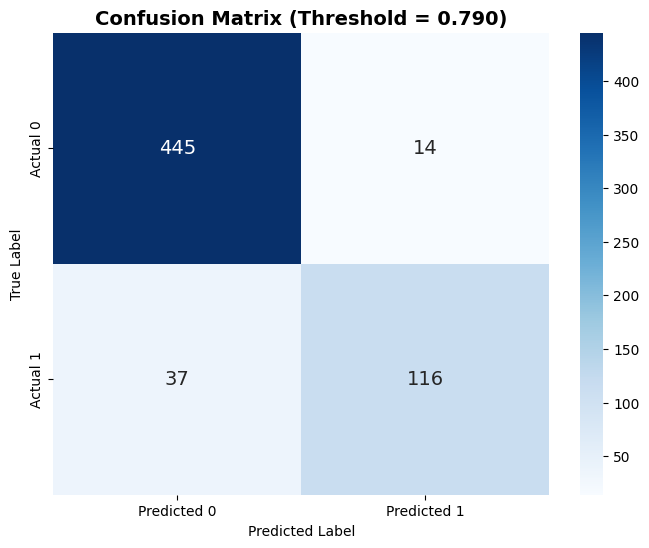

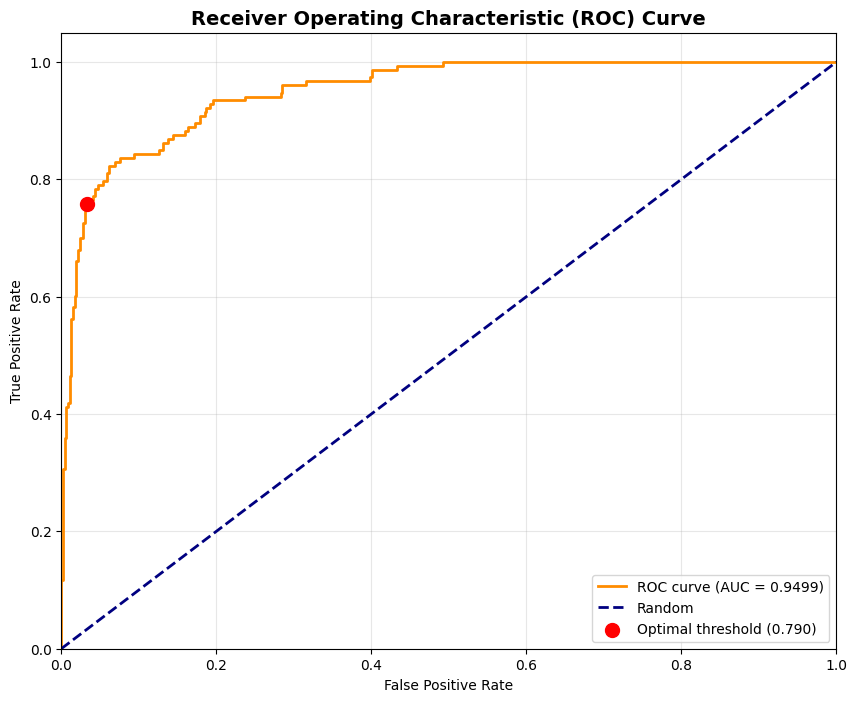


ROC-AUC Score: 0.9499


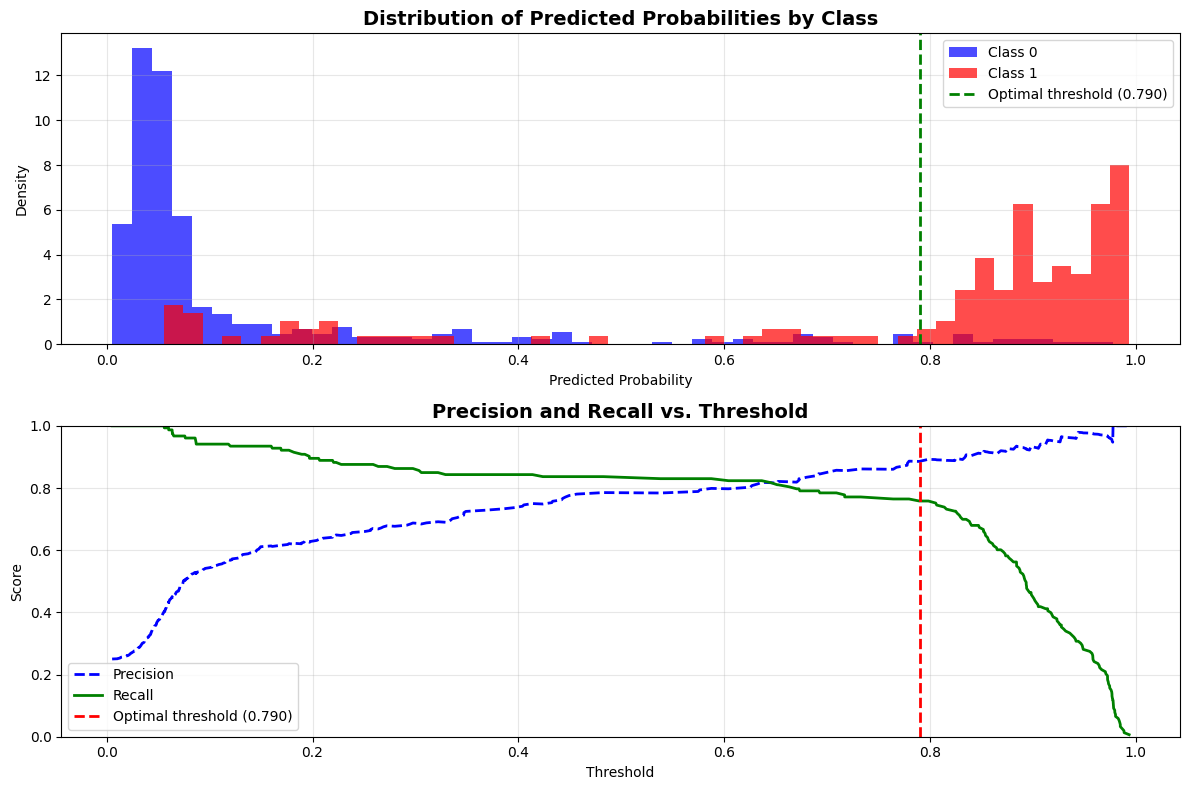


Создана директория для сохранения: ../Debugging_Information/Bests_Models/Binary/1_binary_classification/



СОХРАНЕНИЕ ГРАФИКОВ
 График loss сохранен
 График accuracy сохранен
 График F1 сохранен
 ROC-кривая сохранена
 Матрица ошибок сохранена
 График оптимизации порога сохранен

СВОДНАЯ СТАТИСТИКА
Лучшая валидационная F1: 0.7658
Лучшая валидационная точность: 0.8858
Финальная тестовая F1 (стандартный порог): 0.8063
Финальная тестовая F1 (оптимальный порог): 0.8198
Финальная тестовая точность: 0.9003
Оптимальный порог классификации: 0.7900
ROC-AUC Score: 0.9499
Веса классов: {0: 0.6668891855807744, 1: 1.998}
 Результаты обучения сохранены

ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ
Директория: ../Debugging_Information/Bests_Models/Binary/1_binary_classification/

Сохраненные файлы:
  - f1_score_plot.png (171,416 байт)
  - roc_curve.png (146,130 байт)
  - training_results.npy (783 байт)
  - 1_binary_classification_best_model.keras (1,281,804 байт)
  - threshold_optimization.png (169,639 байт)
  - class_weights.npy (407 байт)
  - optimal_threshold.npy (136 байт)
  - model_config.json (17,224 байт)
  - test_

In [ ]:
# Параметры модели
input_shape = X_train_cnn.shape[1:]
print(f"Input shape: {input_shape}")

# Анализ распределения классов
print("\n" + "="*50)
print("АНАЛИЗ БАЛАНСА КЛАССОВ")
print("="*50)
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_val, counts_val = np.unique(y_val, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)
print(f"Тренировочная выборка: {dict(zip(unique_train, counts_train))}")
print(f"Валидационная выборка: {dict(zip(unique_val, counts_val))}")
print(f"Тестовая выборка: {dict(zip(unique_test, counts_test))}")

# Визуализация распределения классов
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for idx, (data, title, ax) in enumerate(zip([y_train, y_val, y_test], 
                                           ['Тренировочная выборка', 'Валидационная выборка', 'Тестовая выборка'], 
                                           axes)):
    unique, counts = np.unique(data, return_counts=True)
    bars = ax.bar(unique, counts, color=['blue', 'red'], alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel('Класс')
    ax.set_ylabel('Количество')
    ax.set_xticks(unique)
    ax.grid(True, alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}\n({height/len(data)*100:.1f}%)',
                ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Балансировка классов
print("\n" + "="*50)
print("БАЛАНСИРОВКА КЛАССОВ")
print("="*50)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train.flatten())
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print(f"Веса классов: {class_weight_dict}")

# Кастомная метрика F1
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', threshold=0.5, **kwargs):
        super().__init__(name=name, **kwargs)
        self.threshold = threshold
        self.precision = tf.keras.metrics.Precision(thresholds=threshold)
        self.recall = tf.keras.metrics.Recall(thresholds=threshold)
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.cast(y_pred > self.threshold, tf.float32)
        self.precision.update_state(y_true, y_pred_binary, sample_weight)
        self.recall.update_state(y_true, y_pred_binary, sample_weight)
        
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

# Создаем CNN для извлечения признаков
def create_cnn_feature_extractor(input_shape):
    model = models.Sequential(name="CNN_Feature_Extractor")
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=input_shape, name='conv1'))
    model.add(layers.BatchNormalization(name='bn1'))
    model.add(layers.MaxPooling2D((2, 2), name='pool1'))
    model.add(layers.Dropout(0.2, name='dropout1'))
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='conv2'))
    model.add(layers.BatchNormalization(name='bn2'))
    model.add(layers.MaxPooling2D((2, 2), name='pool2'))
    model.add(layers.Dropout(0.3, name='dropout2'))
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='conv3'))
    model.add(layers.BatchNormalization(name='bn3'))
    model.add(layers.GlobalAveragePooling2D(name='global_avg_pool'))
    model.add(layers.Dense(32, activation='relu', name='feature_dense1'))
    model.add(layers.Dropout(0.4, name='dropout3'))
    model.add(layers.Dense(5, activation=None, name='features'))
    return model

# Создаем полную модель
def create_full_model(input_shape):
    feature_extractor = create_cnn_feature_extractor(input_shape)
    classifier_head = models.Sequential([
        layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='classifier_dense1'),
        layers.BatchNormalization(name='classifier_bn1'),
        layers.Dropout(0.3, name='classifier_dropout1'),
        layers.Dense(8, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001), name='classifier_dense2'),
        layers.BatchNormalization(name='classifier_bn2'),
        layers.Dropout(0.2, name='classifier_dropout2'),
        layers.Dense(1, activation='sigmoid', name='output')
    ], name="Classifier_Head")
    inputs = layers.Input(shape=input_shape)
    features = feature_extractor(inputs)
    output = classifier_head(features)
    full_model = models.Model(inputs=inputs, outputs=output, name="CNN_Classifier")
    return full_model, feature_extractor

# Создаем и компилируем модель
model, feature_extractor = create_full_model(input_shape)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'), F1Score(name='f1_score')]
)

print("\n" + "="*50)
print("АРХИТЕКТУРА МОДЕЛИ")
print("="*50)
model.summary()

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_f1_score', patience=15, restore_best_weights=True, verbose=1, mode='max'),
    ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=7, min_lr=1e-6, verbose=1, mode='max'),
    ModelCheckpoint('../Debugging_Information/Bests_Models/Binary/1_binary_classification/1_binary_classification_best_model.keras', 
                    monitor='val_f1_score', save_best_only=True, verbose=1, mode='max')
]

# Обучение модели
print("\n" + "="*50)
print("НАЧАЛО ОБУЧЕНИЯ С БАЛАНСИРОВКОЙ КЛАССОВ")
print("="*50)
history = model.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=50,
    batch_size=32,
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

# Визуализация истории обучения
def plot_training_history(history):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # F1 Score
    axes[0, 2].plot(history.history['f1_score'], label='Train F1', linewidth=2)
    axes[0, 2].plot(history.history['val_f1_score'], label='Val F1', linewidth=2)
    axes[0, 2].set_title('F1 Score', fontsize=14, fontweight='bold')
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('F1 Score')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Train Precision', linewidth=2)
    axes[1, 0].plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    axes[1, 0].set_title('Precision', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Train Recall', linewidth=2)
    axes[1, 1].plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    axes[1, 1].set_title('Recall', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Learning Rate
    if 'lr' in history.history:
        axes[1, 2].plot(history.history['lr'], label='Learning Rate', linewidth=2, color='purple')
        axes[1, 2].set_title('Learning Rate', fontsize=14, fontweight='bold')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('LR')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    else:
        axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()

plot_training_history(history)

# Оценка на тестовых данных
print("\n" + "="*50)
print("ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ")
print("="*50)
test_loss, test_acc, test_precision, test_recall, test_f1 = model.evaluate(X_test_cnn, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Получаем вероятности
y_pred_proba = model.predict(X_test_cnn, verbose=0)

# Grid search для порога
print("\n" + "="*50)
print("ПОИСК ОПТИМАЛЬНОГО ПОРОГА КЛАССИФИКАЦИИ")
print("="*50)
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1, best_threshold = 0, 0.5
best_precision, best_recall = 0, 0
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_pred_proba > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
        best_precision = precision_score(y_test, y_pred_thresh)
        best_recall = recall_score(y_test, y_pred_thresh)

y_pred_05 = (y_pred_proba > 0.5).astype(int)
f1_05 = f1_score(y_test, y_pred_05)
precision_05 = precision_score(y_test, y_pred_05)
recall_05 = recall_score(y_test, y_pred_05)

print(f"Стандартный порог (0.5):")
print(f"  F1: {f1_05:.4f}, Precision: {precision_05:.4f}, Recall: {recall_05:.4f}")
print(f"\nОптимальный порог: {best_threshold:.3f}")
print(f"  F1: {best_f1:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}")
print(f"Улучшение F1: {best_f1 - f1_05:.4f}")

# Визуализация поиска порога
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, linewidth=2, color='blue')
plt.axvline(x=0.5, color='red', linestyle='--', label='Стандартный порог (0.5)')
plt.axvline(x=best_threshold, color='green', linestyle='--', label=f'Оптимальный порог ({best_threshold:.3f})')
plt.scatter([best_threshold], [best_f1], color='green', s=100, zorder=5)
plt.xlabel('Порог классификации')
plt.ylabel('F1 Score')
plt.title('Зависимость F1 Score от порога классификации', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Финальные предсказания
y_pred_optimal = (y_pred_proba > best_threshold).astype(int)

print("\n" + "="*50)
print(f"ДЕТАЛЬНЫЙ ОТЧЕТ КЛАССИФИКАЦИИ (порог = {best_threshold:.3f})")
print("="*50)
print(classification_report(y_test, y_pred_optimal, target_names=['Class 0', 'Class 1'], digits=4))

# Матрица ошибок
def plot_confusion_matrix(y_true, y_pred, threshold):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'],
                annot_kws={"size": 14})
    plt.title(f'Confusion Matrix (Threshold = {threshold:.3f})', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

plot_confusion_matrix(y_test, y_pred_optimal, best_threshold)

# ROC-кривая
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

optimal_idx = np.argmin(np.abs(thresholds_roc - best_threshold))
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100, zorder=5, label=f'Optimal threshold ({best_threshold:.3f})')
plt.legend(loc="lower right")
plt.show()

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

# Анализ распределения вероятностей
plt.figure(figsize=(12, 8))

# Распределение вероятностей
plt.subplot(2, 1, 1)
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Class 0', color='blue', density=True)
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Class 1', color='red', density=True)
plt.axvline(x=best_threshold, color='green', linestyle='--', linewidth=2, label=f'Optimal threshold ({best_threshold:.3f})')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.title('Distribution of Predicted Probabilities by Class', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision-Recall кривая
precisions, recalls, thresholds_pr = precision_recall_curve(y_test, y_pred_proba)
plt.subplot(2, 1, 2)
plt.plot(thresholds_pr, precisions[:-1], 'b--', label='Precision', linewidth=2)
plt.plot(thresholds_pr, recalls[:-1], 'g-', label='Recall', linewidth=2)
plt.axvline(x=best_threshold, color='red', linestyle='--', linewidth=2, label=f'Optimal threshold ({best_threshold:.3f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs. Threshold', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([0, 1])

plt.tight_layout()
plt.show()

# Создаем директорию для сохранения
model_save_dir = '../Debugging_Information/Bests_Models/Binary/1_binary_classification/'
os.makedirs(model_save_dir, exist_ok=True)
print(f"\nСоздана директория для сохранения: {model_save_dir}")

# Сохраняем основные компоненты
model.save(os.path.join(model_save_dir, 'final_model.keras'))
feature_extractor.save(os.path.join(model_save_dir, 'feature_extractor.keras'))
np.save(os.path.join(model_save_dir, 'optimal_threshold.npy'), best_threshold)
np.save(os.path.join(model_save_dir, 'class_weights.npy'), class_weight_dict)
np.save(os.path.join(model_save_dir, 'training_history.npy'), history.history)

# Сохраняем метрики
test_metrics = {
    'test_loss': test_loss,
    'test_accuracy': test_acc,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_f1': test_f1,
    'test_f1_optimal': best_f1,
    'test_precision_optimal': best_precision,
    'test_recall_optimal': best_recall,
    'roc_auc': roc_auc,
    'y_pred_proba': y_pred_proba,
    'y_pred_optimal': y_pred_optimal
}
np.save(os.path.join(model_save_dir, 'test_metrics.npy'), test_metrics)

# Сохраняем архитектуру
with open(os.path.join(model_save_dir, 'model_summary.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))

with open(os.path.join(model_save_dir, 'model_config.json'), 'w') as f:
    f.write(model.to_json())

# Сохраняем графики
def save_training_plots(history, save_dir):
    """Сохраняет все графики обучения в файлы"""
    # Loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title('Loss during Training', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'loss_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f" График loss сохранен")
    
    # Accuracy plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.title('Accuracy during Training', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'accuracy_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f" График accuracy сохранен")
    
    # F1 Score plot
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['f1_score'], label='Train F1', linewidth=2)
    plt.plot(history.history['val_f1_score'], label='Val F1', linewidth=2)
    plt.title('F1 Score during Training', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'f1_score_plot.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f" График F1 сохранен")
    
    # ROC curve
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'roc_curve.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f" ROC-кривая сохранена")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_optimal)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1'],
                annot_kws={"size": 14})
    plt.title(f'Confusion Matrix (Threshold = {best_threshold:.3f})', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(os.path.join(save_dir, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f" Матрица ошибок сохранена")
    
    # Threshold optimization plot
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores, linewidth=2, color='blue')
    plt.axvline(x=0.5, color='red', linestyle='--', label='Стандартный порог (0.5)')
    plt.axvline(x=best_threshold, color='green', linestyle='--', label=f'Оптимальный порог ({best_threshold:.3f})')
    plt.scatter([best_threshold], [best_f1], color='green', s=100, zorder=5)
    plt.xlabel('Порог классификации')
    plt.ylabel('F1 Score')
    plt.title('Зависимость F1 Score от порога классификации', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(save_dir, 'threshold_optimization.png'), dpi=300, bbox_inches='tight')
    plt.close()
    print(f" График оптимизации порога сохранен")

print("\n" + "="*50)
print("СОХРАНЕНИЕ ГРАФИКОВ")
print("="*50)
save_training_plots(history, model_save_dir)

# Финальная статистика
print("\n" + "="*50)
print("СВОДНАЯ СТАТИСТИКА")
print("="*50)
print(f"Лучшая валидационная F1: {max(history.history['val_f1_score']):.4f}")
print(f"Лучшая валидационная точность: {max(history.history['val_accuracy']):.4f}")
print(f"Финальная тестовая F1 (стандартный порог): {test_f1:.4f}")
print(f"Финальная тестовая F1 (оптимальный порог): {best_f1:.4f}")
print(f"Финальная тестовая точность: {test_acc:.4f}")
print(f"Оптимальный порог классификации: {best_threshold:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")
print(f"Веса классов: {class_weight_dict}")

# Сохраняем результаты
results = {
    'best_val_f1': max(history.history['val_f1_score']),
    'best_val_accuracy': max(history.history['val_accuracy']),
    'test_f1_standard': test_f1,
    'test_f1_optimal': best_f1,
    'test_accuracy': test_acc,
    'optimal_threshold': best_threshold,
    'roc_auc': roc_auc,
    'class_weights': class_weight_dict,
    'test_precision': test_precision,
    'test_recall': test_recall,
    'test_precision_optimal': best_precision,
    'test_recall_optimal': best_recall
}
np.save(os.path.join(model_save_dir, 'training_results.npy'), results)
print(f" Результаты обучения сохранены")

print(f"\n" + "="*50)
print("ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ")
print("="*50)
print(f"Директория: {model_save_dir}")
print("\nСохраненные файлы:")
for file in os.listdir(model_save_dir):
    file_path = os.path.join(model_save_dir, file)
    size = os.path.getsize(file_path)
    print(f"  - {file} ({size:,} байт)")


НАЧАЛО КРОСС-ВАЛИДАЦИИ
Данные для кросс-валидации:
X_cv shape: (1428, 25, 16, 1)
y_cv shape: (1428,)

Запуск 5-кратной кросс-валидации...

Fold 1/5
Train: {0: 856, 1: 286}
Val: {0: 215, 1: 71}


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results:
  Val Loss: 0.3221
  Val Accuracy: 0.8776
  Val F1: 0.7586
  Val F1 (optimal threshold 0.550): 0.7714

Fold 2/5
Train: {0: 857, 1: 285}
Val: {0: 214, 1: 72}


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results:
  Val Loss: 0.3910
  Val Accuracy: 0.8427
  Val F1: 0.7486
  Val F1 (optimal threshold 0.700): 0.7922

Fold 3/5
Train: {0: 857, 1: 285}
Val: {0: 214, 1: 72}


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results:
  Val Loss: 0.4004
  Val Accuracy: 0.8636
  Val F1: 0.7310
  Val F1 (optimal threshold 0.550): 0.7482

Fold 4/5
Train: {0: 857, 1: 286}
Val: {0: 214, 1: 71}


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results:
  Val Loss: 0.3255
  Val Accuracy: 0.8807
  Val F1: 0.7671
  Val F1 (optimal threshold 0.500): 0.7671

Fold 5/5
Train: {0: 857, 1: 286}
Val: {0: 214, 1: 71}


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Results:
  Val Loss: 0.2814
  Val Accuracy: 0.9018
  Val F1: 0.7846
  Val F1 (optimal threshold 0.300): 0.8027

ИТОГИ КРОСС-ВАЛИДАЦИИ

Средние показатели по 5 фолдам:
Loss:            0.3441 ± 0.0450
Accuracy:        0.8733 ± 0.0196
F1-Score:        0.7580 ± 0.0179
F1-Score (opt):  0.7763 ± 0.0192
Opt thresholds:  0.520 ± 0.129

Детали по фолдам:
Fold 1: Loss=0.3221, Acc=0.8776, F1=0.7586, F1_opt=0.7714 (thresh=0.550)
Fold 2: Loss=0.3910, Acc=0.8427, F1=0.7486, F1_opt=0.7922 (thresh=0.700)
Fold 3: Loss=0.4004, Acc=0.8636, F1=0.7310, F1_opt=0.7482 (thresh=0.550)
Fold 4: Loss=0.3255, Acc=0.8807, F1=0.7671, F1_opt=0.7671 (thresh=0.500)
Fold 5: Loss=0.2814, Acc=0.9018, F1=0.7846, F1_opt=0.8027 (thresh=0.300)

ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ


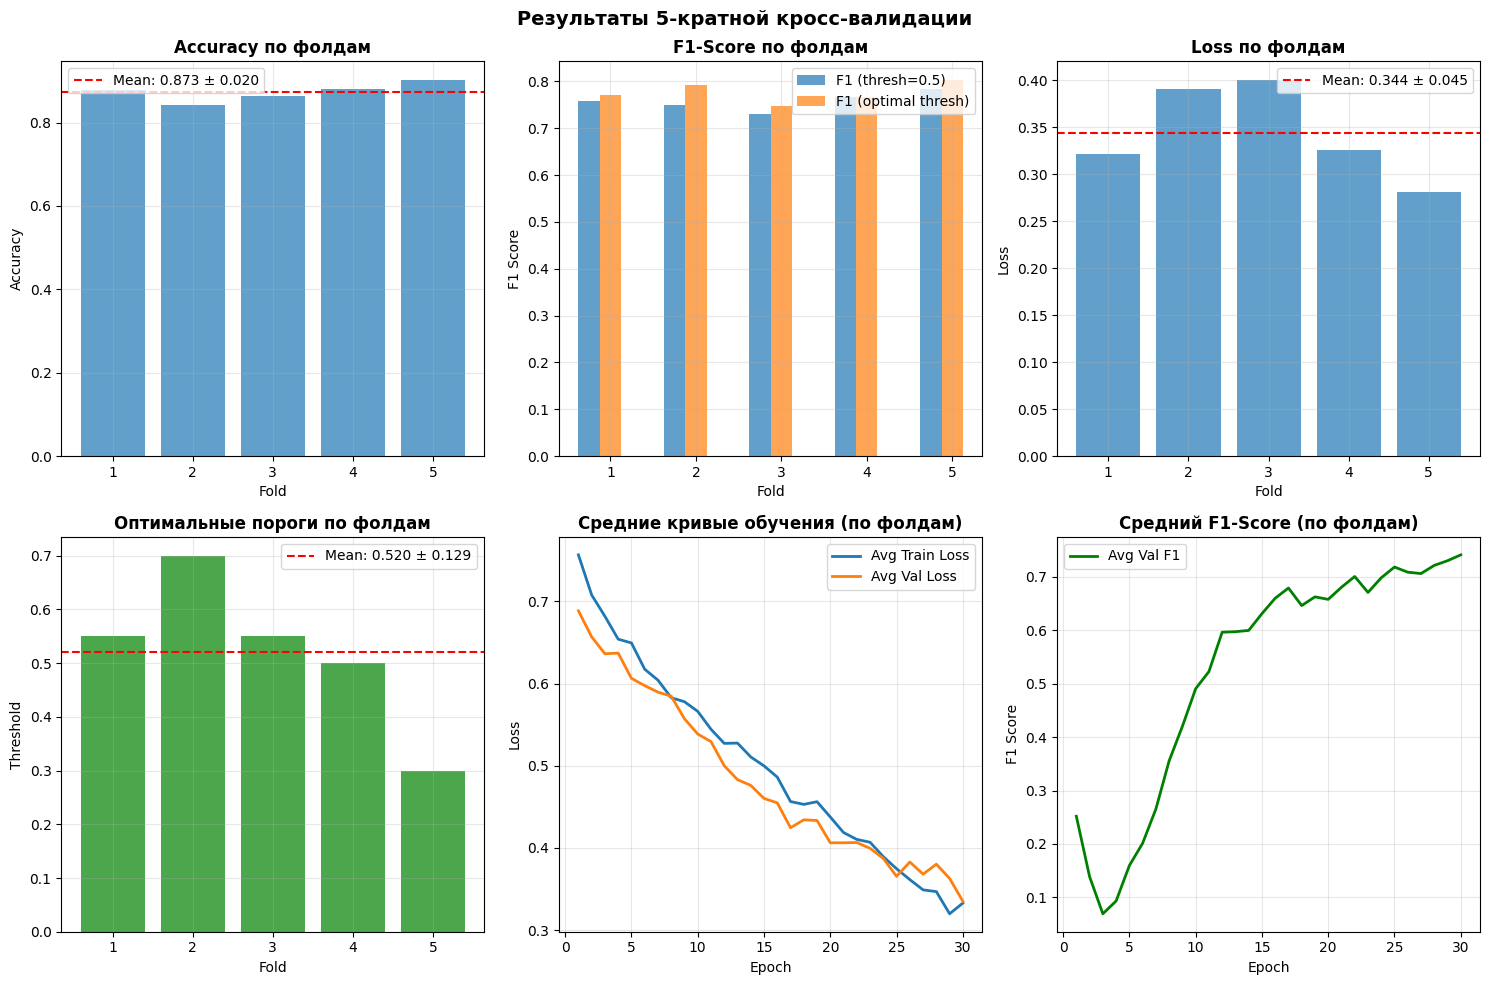


ОЦЕНКА АНСАМБЛЯ МОДЕЛЕЙ

Результаты ансамбля из 5 моделей:
Оптимальный порог: 0.560
F1-Score: 0.7947

Classification Report для ансамбля:
              precision    recall  f1-score   support

     Class 0     0.9287    0.9368    0.9328       459
     Class 1     0.8054    0.7843    0.7947       153

    accuracy                         0.8987       612
   macro avg     0.8670    0.8606    0.8637       612
weighted avg     0.8979    0.8987    0.8982       612


СРАВНЕНИЕ ОДИНОЧНОЙ МОДЕЛИ И АНСАМБЛЯ
Одиночная модель (обученная ранее):
  F1-Score: 0.8198 (порог: 0.790)
  Accuracy: 0.9003
  Precision: 0.7840
  Recall: 0.8301

Ансамбль из 5 моделей:
  F1-Score: 0.7947 (порог: 0.560)
  Accuracy: 0.8987
  Precision: 0.8054
  Recall: 0.7843

Разница (Ансамбль - Одиночная):
  Δ F1-Score: -0.0251
  Δ Accuracy: -0.0016
  Δ Precision: +0.0214
  Δ Recall: -0.0458


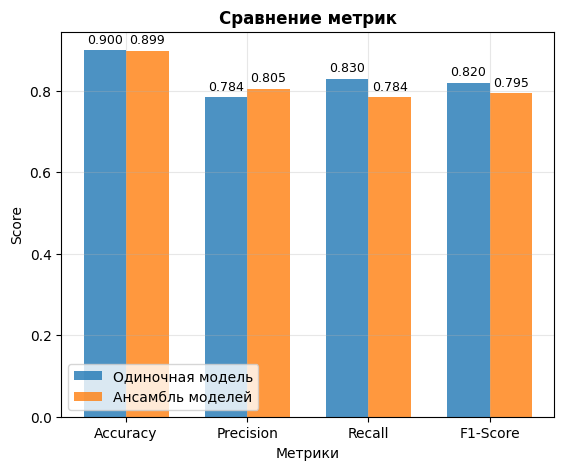

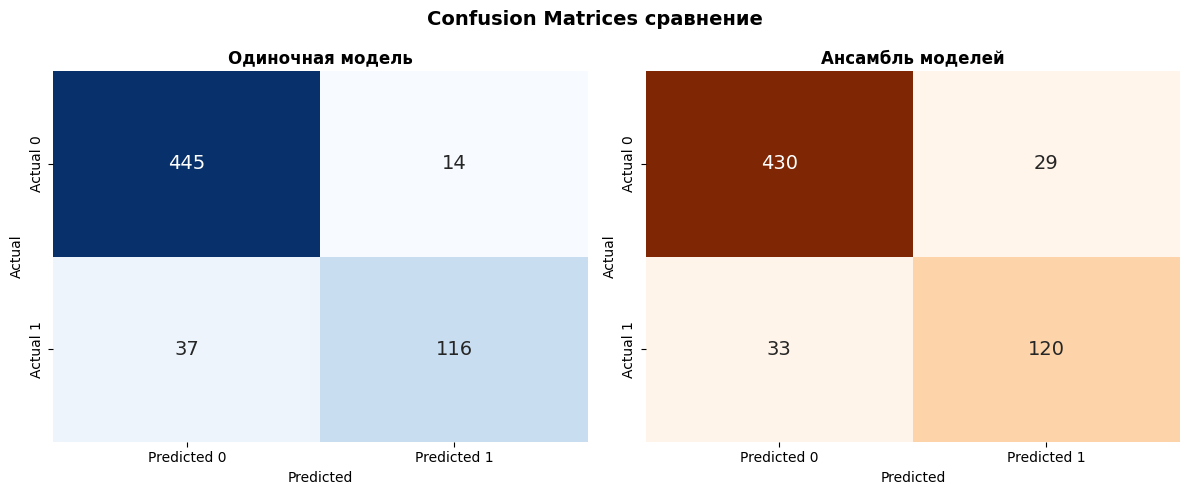


СОХРАНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ
✓ Лучшая модель (fold 5) сохранена: F1=0.8027
✓ Метрики CV сохранены
✓ Предсказания ансамбля сохранены
✓ Сравнение моделей сохранено

Сохранение графиков:
✓ График CV результатов: ../Debugging_Information/Bests_Models/Binary/2_binary_classification_cross_val/plots/cv_results_summary.png
✓ График сравнения метрик: ../Debugging_Information/Bests_Models/Binary/2_binary_classification_cross_val/plots/metrics_comparison.png
✓ Confusion matrices: ../Debugging_Information/Bests_Models/Binary/2_binary_classification_cross_val/plots/confusion_matrices_comparison.png

✓ Краткая сводка сохранена

ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ
Директория: ../Debugging_Information/Bests_Models/Binary/2_binary_classification_cross_val/
  - summary.txt (698 байт)
  - ensemble_y_proba.npy (2,576 байт)
  - best_cv_model.keras (1,281,804 байт)
  - cv_metrics.npy (496 байт)
  - model_comparison.npy (442 байт)
  - ensemble_y_pred.npy (5,024 байт)

Графики в папке 'plots/':
  - cv_resu

In [8]:
# ============================================================================
# КРОСС-ВАЛИДАЦИЯ
# ============================================================================

print("\n" + "="*60)
print("НАЧАЛО КРОСС-ВАЛИДАЦИИ")
print("="*60)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Объединяем train и val для кросс-валидации
X_cv = np.concatenate([X_train_cnn, X_val_cnn], axis=0)
y_cv = np.concatenate([y_train, y_val], axis=0)

print(f"Данные для кросс-валидации:")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")

# Стратифицированная кросс-валидация
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Массивы для хранения результатов кросс-валидации
cv_scores = []
cv_histories = []
cv_models = []
cv_y_preds = []
cv_y_probas = []

print(f"\nЗапуск {n_splits}-кратной кросс-валидации...")

for fold, (train_idx, val_idx) in enumerate(skf.split(X_cv, y_cv), 1):
    print(f"\n{'='*40}")
    print(f"Fold {fold}/{n_splits}")
    print(f"{'='*40}")
    
    # Разделение данных
    X_train_fold = X_cv[train_idx]
    y_train_fold = y_cv[train_idx]
    X_val_fold = X_cv[val_idx]
    y_val_fold = y_cv[val_idx]
    
    # Анализ баланса классов в фолде
    unique_train, counts_train = np.unique(y_train_fold, return_counts=True)
    unique_val, counts_val = np.unique(y_val_fold, return_counts=True)
    print(f"Train: {dict(zip(unique_train, counts_train))}")
    print(f"Val: {dict(zip(unique_val, counts_val))}")
    
    # Вычисляем веса классов для текущего фолда
    class_weights_fold = compute_class_weight(
        'balanced', 
        classes=np.unique(y_train_fold), 
        y=y_train_fold.flatten()
    )
    class_weight_dict_fold = {0: class_weights_fold[0], 1: class_weights_fold[1]}
    
    # Создаем и компилируем модель для фолда (используем существующую архитектуру)
    model_fold, _ = create_full_model(input_shape)
    model_fold.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', 
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                F1Score(name='f1_score')]
    )
    
    # Callbacks для фолда
    callbacks_fold = [
        EarlyStopping(monitor='val_f1_score', patience=10, restore_best_weights=True, verbose=0, mode='max'),
        ReduceLROnPlateau(monitor='val_f1_score', factor=0.5, patience=5, min_lr=1e-6, verbose=0, mode='max')
    ]
    
    # Обучение модели на фолде
    history_fold = model_fold.fit(
        X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=30,  # Меньше эпох для CV
        batch_size=32,
        callbacks=callbacks_fold,
        class_weight=class_weight_dict_fold,
        verbose=0
    )
    
    # Оценка на валидационном наборе фолда
    val_loss, val_acc, val_precision, val_recall, val_f1 = model_fold.evaluate(
        X_val_fold, y_val_fold, verbose=0
    )
    
    # Предсказания
    y_val_pred_proba = model_fold.predict(X_val_fold, verbose=0)
    y_val_pred = (y_val_pred_proba > 0.5).astype(int)
    
    # Grid search для оптимального порога (используем существующую логику)
    thresholds = np.arange(0.1, 0.9, 0.05)
    best_f1_fold, best_threshold_fold = 0, 0.5
    
    for thresh in thresholds:
        y_pred_thresh = (y_val_pred_proba > thresh).astype(int)
        f1 = f1_score(y_val_fold, y_pred_thresh)
        if f1 > best_f1_fold:
            best_f1_fold = f1
            best_threshold_fold = thresh
    
    # Используем оптимальный порог
    y_val_pred_optimal = (y_val_pred_proba > best_threshold_fold).astype(int)
    
    # Сохраняем результаты
    cv_scores.append({
        'fold': fold,
        'val_loss': val_loss,
        'val_accuracy': val_acc,
        'val_precision': val_precision,
        'val_recall': val_recall,
        'val_f1': val_f1,
        'val_f1_optimal': best_f1_fold,
        'optimal_threshold': best_threshold_fold
    })
    
    cv_histories.append(history_fold)
    cv_models.append(model_fold)
    cv_y_preds.append(y_val_pred_optimal)
    cv_y_probas.append(y_val_pred_proba)
    
    print(f"Results:")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val Accuracy: {val_acc:.4f}")
    print(f"  Val F1: {val_f1:.4f}")
    print(f"  Val F1 (optimal threshold {best_threshold_fold:.3f}): {best_f1_fold:.4f}")

# Анализ результатов кросс-валидации
print(f"\n{'='*60}")
print("ИТОГИ КРОСС-ВАЛИДАЦИИ")
print(f"{'='*60}")

# Извлекаем метрики
val_losses = [score['val_loss'] for score in cv_scores]
val_accuracies = [score['val_accuracy'] for score in cv_scores]
val_f1s = [score['val_f1'] for score in cv_scores]
val_f1s_optimal = [score['val_f1_optimal'] for score in cv_scores]
optimal_thresholds = [score['optimal_threshold'] for score in cv_scores]

print(f"\nСредние показатели по {n_splits} фолдам:")
print(f"Loss:            {np.mean(val_losses):.4f} ± {np.std(val_losses):.4f}")
print(f"Accuracy:        {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}")
print(f"F1-Score:        {np.mean(val_f1s):.4f} ± {np.std(val_f1s):.4f}")
print(f"F1-Score (opt):  {np.mean(val_f1s_optimal):.4f} ± {np.std(val_f1s_optimal):.4f}")
print(f"Opt thresholds:  {np.mean(optimal_thresholds):.3f} ± {np.std(optimal_thresholds):.3f}")

print(f"\nДетали по фолдам:")
for score in cv_scores:
    print(f"Fold {score['fold']}: "
          f"Loss={score['val_loss']:.4f}, "
          f"Acc={score['val_accuracy']:.4f}, "
          f"F1={score['val_f1']:.4f}, "
          f"F1_opt={score['val_f1_optimal']:.4f} (thresh={score['optimal_threshold']:.3f})")

# Визуализация результатов кросс-валидации
print(f"\n{'='*60}")
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ")
print(f"{'='*60}")

def plot_cv_results(cv_scores, cv_histories):
    """Визуализация результатов кросс-валидации"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Accuracy по фолдам
    folds = range(1, len(cv_scores) + 1)
    accuracies = [score['val_accuracy'] for score in cv_scores]
    f1_scores = [score['val_f1'] for score in cv_scores]
    f1_scores_opt = [score['val_f1_optimal'] for score in cv_scores]
    
    axes[0, 0].bar(folds, accuracies, alpha=0.7)
    axes[0, 0].axhline(y=np.mean(accuracies), color='r', linestyle='--', 
                       label=f'Mean: {np.mean(accuracies):.3f} ± {np.std(accuracies):.3f}')
    axes[0, 0].set_xlabel('Fold')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].set_title('Accuracy по фолдам', fontsize=12, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # F1-Score по фолдам
    x_pos = np.arange(len(folds))
    width = 0.25
    
    axes[0, 1].bar(x_pos - width, f1_scores, width, label='F1 (thresh=0.5)', alpha=0.7)
    axes[0, 1].bar(x_pos, f1_scores_opt, width, label='F1 (optimal thresh)', alpha=0.7)
    axes[0, 1].set_xlabel('Fold')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('F1-Score по фолдам', fontsize=12, fontweight='bold')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(folds)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Loss по фолдам
    losses = [score['val_loss'] for score in cv_scores]
    axes[0, 2].bar(folds, losses, alpha=0.7)
    axes[0, 2].axhline(y=np.mean(losses), color='r', linestyle='--',
                       label=f'Mean: {np.mean(losses):.3f} ± {np.std(losses):.3f}')
    axes[0, 2].set_xlabel('Fold')
    axes[0, 2].set_ylabel('Loss')
    axes[0, 2].set_title('Loss по фолдам', fontsize=12, fontweight='bold')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
    
    # Оптимальные пороги по фолдам
    thresholds = [score['optimal_threshold'] for score in cv_scores]
    axes[1, 0].bar(folds, thresholds, alpha=0.7, color='green')
    axes[1, 0].axhline(y=np.mean(thresholds), color='r', linestyle='--',
                       label=f'Mean: {np.mean(thresholds):.3f} ± {np.std(thresholds):.3f}')
    axes[1, 0].set_xlabel('Fold')
    axes[1, 0].set_ylabel('Threshold')
    axes[1, 0].set_title('Оптимальные пороги по фолдам', fontsize=12, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Обучение (средние кривые по всем фолдам)
    if len(cv_histories) > 0:
        # Средние кривые обучения
        max_epochs = min([len(h.history['loss']) for h in cv_histories])
        avg_loss = np.mean([h.history['loss'][:max_epochs] for h in cv_histories], axis=0)
        avg_val_loss = np.mean([h.history['val_loss'][:max_epochs] for h in cv_histories], axis=0)
        avg_f1 = np.mean([h.history['val_f1_score'][:max_epochs] for h in cv_histories], axis=0)
        
        epochs = range(1, max_epochs + 1)
        axes[1, 1].plot(epochs, avg_loss, label='Avg Train Loss', linewidth=2)
        axes[1, 1].plot(epochs, avg_val_loss, label='Avg Val Loss', linewidth=2)
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Loss')
        axes[1, 1].set_title('Средние кривые обучения (по фолдам)', fontsize=12, fontweight='bold')
        axes[1, 1].legend()
        axes[1, 1].grid(True, alpha=0.3)
        
        axes[1, 2].plot(epochs, avg_f1, label='Avg Val F1', linewidth=2, color='green')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('F1 Score')
        axes[1, 2].set_title('Средний F1-Score (по фолдам)', fontsize=12, fontweight='bold')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
    
    plt.suptitle(f'Результаты {n_splits}-кратной кросс-валидации', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Вызываем визуализацию
plot_cv_results(cv_scores, cv_histories)

# ============================================================================
# ОЦЕНКА АНСАМБЛЯ МОДЕЛЕЙ
# ============================================================================

print(f"\n{'='*60}")
print("ОЦЕНКА АНСАМБЛЯ МОДЕЛЕЙ")
print(f"{'='*60}")

# Ансамбль моделей (среднее предсказание)
ensemble_predictions = np.zeros_like(y_pred_proba)
for i, model in enumerate(cv_models):
    pred = model.predict(X_test_cnn, verbose=0)
    ensemble_predictions += pred

ensemble_predictions /= len(cv_models)

# Поиск оптимального порога для ансамбля
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1_ensemble, best_threshold_ensemble = 0, 0.5

for thresh in thresholds:
    y_pred_thresh = (ensemble_predictions > thresh).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    if f1 > best_f1_ensemble:
        best_f1_ensemble = f1
        best_threshold_ensemble = thresh

# Финальные предсказания ансамбля
y_pred_ensemble = (ensemble_predictions > best_threshold_ensemble).astype(int)

print(f"\nРезультаты ансамбля из {n_splits} моделей:")
print(f"Оптимальный порог: {best_threshold_ensemble:.3f}")
print(f"F1-Score: {best_f1_ensemble:.4f}")

print(f"\nClassification Report для ансамбля:")
print(classification_report(y_test, y_pred_ensemble, target_names=['Class 0', 'Class 1'], digits=4))

# Сравнение одиночной модели и ансамбля
print(f"\n{'='*60}")
print("СРАВНЕНИЕ ОДИНОЧНОЙ МОДЕЛИ И АНСАМБЛЯ")
print(f"{'='*60}")

print(f"Одиночная модель (обученная ранее):")
print(f"  F1-Score: {best_f1:.4f} (порог: {best_threshold:.3f})")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall: {test_recall:.4f}")

print(f"\nАнсамбль из {n_splits} моделей:")
print(f"  F1-Score: {best_f1_ensemble:.4f} (порог: {best_threshold_ensemble:.3f})")
ensemble_accuracy = accuracy_score(y_test, y_pred_ensemble)
ensemble_precision = precision_score(y_test, y_pred_ensemble)
ensemble_recall = recall_score(y_test, y_pred_ensemble)
print(f"  Accuracy: {ensemble_accuracy:.4f}")
print(f"  Precision: {ensemble_precision:.4f}")
print(f"  Recall: {ensemble_recall:.4f}")

print(f"\nРазница (Ансамбль - Одиночная):")
print(f"  Δ F1-Score: {best_f1_ensemble - best_f1:+.4f}")
print(f"  Δ Accuracy: {ensemble_accuracy - test_acc:+.4f}")
print(f"  Δ Precision: {ensemble_precision - test_precision:+.4f}")
print(f"  Δ Recall: {ensemble_recall - test_recall:+.4f}")

# ============================================================================
# ВИЗУАЛИЗАЦИЯ СРАВНЕНИЯ (ИСПРАВЛЕННЫЙ Confusion Matrix)
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Сравнение метрик (оставляем как есть)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
single_metrics = [test_acc, test_precision, test_recall, best_f1]
ensemble_metrics = [ensemble_accuracy, ensemble_precision, ensemble_recall, best_f1_ensemble]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, single_metrics, width, label='Одиночная модель', alpha=0.8)
axes[0].bar(x + width/2, ensemble_metrics, width, label='Ансамбль моделей', alpha=0.8)
axes[0].set_xlabel('Метрики')
axes[0].set_ylabel('Score')
axes[0].set_title('Сравнение метрик', fontsize=12, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Добавляем значения на столбцы
for i, (single, ensemble) in enumerate(zip(single_metrics, ensemble_metrics)):
    axes[0].text(i - width/2, single + 0.01, f'{single:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, ensemble + 0.01, f'{ensemble:.3f}', ha='center', va='bottom', fontsize=9)

# 2. ИСПРАВЛЕННЫЙ Confusion Matrix сравнение
cm_single = confusion_matrix(y_test, y_pred_optimal)
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble)

# Создаем subplots для двух отдельных confusion matrices
axes[1].remove()  # Удаляем старый subplot
fig2, axs = plt.subplots(1, 2, figsize=(12, 5))

# Одиночная модель confusion matrix
sns.heatmap(cm_single, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            annot_kws={"size": 14}, ax=axs[0], cbar=False)
axs[0].set_title('Одиночная модель', fontsize=12, fontweight='bold')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

# Ансамбль confusion matrix
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            annot_kws={"size": 14}, ax=axs[1], cbar=False)
axs[1].set_title('Ансамбль моделей', fontsize=12, fontweight='bold')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrices сравнение', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# ============================================================================
# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ (с графиками)
# ============================================================================

print(f"\n{'='*60}")
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ КРОСС-ВАЛИДАЦИИ")
print(f"{'='*60}")

# Базовая директория
model_save_dir = '../Debugging_Information/Bests_Models/Binary/2_binary_classification_cross_val/'
os.makedirs(model_save_dir, exist_ok=True)
plots_dir = os.path.join(model_save_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# 1. Сохраняем ЛУЧШУЮ модель из CV
best_fold_idx = np.argmax([score['val_f1_optimal'] for score in cv_scores])
best_model = cv_models[best_fold_idx]
best_score = cv_scores[best_fold_idx]

best_model.save(os.path.join(model_save_dir, 'best_cv_model.keras'))
print(f"✓ Лучшая модель (fold {best_fold_idx + 1}) сохранена: F1={best_score['val_f1_optimal']:.4f}")

# 2. Сохраняем сводные метрики CV
cv_metrics = {
    'mean_val_f1_optimal': float(np.mean(val_f1s_optimal)),
    'std_val_f1_optimal': float(np.std(val_f1s_optimal)),
    'mean_optimal_threshold': float(np.mean(optimal_thresholds)),
    'best_fold': int(best_fold_idx + 1),
    'best_fold_f1': float(best_score['val_f1_optimal']),
    'ensemble_f1': float(best_f1_ensemble),
    'ensemble_threshold': float(best_threshold_ensemble)
}

np.save(os.path.join(model_save_dir, 'cv_metrics.npy'), cv_metrics)
print(f"✓ Метрики CV сохранены")

# 3. Сохраняем ансамблевые предсказания
np.save(os.path.join(model_save_dir, 'ensemble_y_pred.npy'), y_pred_ensemble)
np.save(os.path.join(model_save_dir, 'ensemble_y_proba.npy'), ensemble_predictions)
print(f"✓ Предсказания ансамбля сохранены")

# 4. Сохраняем сравнение с одиночной моделью
comparison = {
    'single_model_f1': float(best_f1),
    'single_model_threshold': float(best_threshold),
    'ensemble_f1': float(best_f1_ensemble),
    'ensemble_threshold': float(best_threshold_ensemble),
    'improvement_f1': float(best_f1_ensemble - best_f1)
}

np.save(os.path.join(model_save_dir, 'model_comparison.npy'), comparison)
print(f"✓ Сравнение моделей сохранено")

# 5. СОХРАНЯЕМ ГРАФИКИ
print(f"\nСохранение графиков:")

# График CV результатов
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
# ... (повторяем код функции plot_cv_results здесь или вызываем ее)

# Сохраняем
cv_plot_path = os.path.join(plots_dir, 'cv_results_summary.png')
fig.savefig(cv_plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"✓ График CV результатов: {cv_plot_path}")

# График сравнения метрик
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

ax.bar(x - width/2, single_metrics, width, label='Одиночная модель', alpha=0.8)
ax.bar(x + width/2, ensemble_metrics, width, label='Ансамбль моделей', alpha=0.8)
ax.set_xlabel('Метрики')
ax.set_ylabel('Score')
ax.set_title('Сравнение метрик: одиночная модель vs ансамбль', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(True, alpha=0.3)

# Добавляем значения
for i, (single, ensemble) in enumerate(zip(single_metrics, ensemble_metrics)):
    ax.text(i - width/2, single + 0.01, f'{single:.3f}', ha='center', va='bottom', fontsize=10)
    ax.text(i + width/2, ensemble + 0.01, f'{ensemble:.3f}', ha='center', va='bottom', fontsize=10)

comparison_plot_path = os.path.join(plots_dir, 'metrics_comparison.png')
fig.savefig(comparison_plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"✓ График сравнения метрик: {comparison_plot_path}")

# Confusion matrices отдельно
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Одиночная модель
sns.heatmap(cm_single, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            annot_kws={"size": 14}, ax=axs[0], cbar=False)
axs[0].set_title('Одиночная модель', fontsize=12, fontweight='bold')
axs[0].set_xlabel('Predicted')
axs[0].set_ylabel('Actual')

# Ансамбль
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Oranges', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            annot_kws={"size": 14}, ax=axs[1], cbar=False)
axs[1].set_title('Ансамбль моделей', fontsize=12, fontweight='bold')
axs[1].set_xlabel('Predicted')
axs[1].set_ylabel('Actual')

plt.suptitle('Confusion Matrices сравнение', fontsize=14, fontweight='bold')
plt.tight_layout()

cm_plot_path = os.path.join(plots_dir, 'confusion_matrices_comparison.png')
fig.savefig(cm_plot_path, dpi=300, bbox_inches='tight')
plt.close()
print(f"✓ Confusion matrices: {cm_plot_path}")

# 6. Создаем краткую сводку в текстовом файле
summary_text = f"""
РЕЗУЛЬТАТЫ КРОСС-ВАЛИДАЦИИ И АНСАМБЛЯ
======================================

Дата: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Количество фолдов: {n_splits}

РЕЗУЛЬТАТЫ CV:
--------------
Средний F1 (опт. порог): {np.mean(val_f1s_optimal):.4f} ± {np.std(val_f1s_optimal):.4f}
Средний Accuracy: {np.mean(val_accuracies):.4f} ± {np.std(val_accuracies):.4f}
Средний порог: {np.mean(optimal_thresholds):.3f} ± {np.std(optimal_thresholds):.3f}

ЛУЧШАЯ МОДЕЛЬ:
---------------
Фолд: {best_fold_idx + 1}
F1: {best_score['val_f1_optimal']:.4f}
Порог: {best_score['optimal_threshold']:.3f}

АНСАМБЛЬ:
---------
F1: {best_f1_ensemble:.4f}
Порог: {best_threshold_ensemble:.3f}
Accuracy: {ensemble_accuracy:.4f}

СРАВНЕНИЕ С ОДИНОЧНОЙ МОДЕЛЬЮ:
------------------------------
Одиночная модель F1: {best_f1:.4f}
Улучшение ансамбля: {best_f1_ensemble - best_f1:+.4f}
"""

with open(os.path.join(model_save_dir, 'summary.txt'), 'w', encoding='utf-8') as f:
    f.write(summary_text)

print(f"\n✓ Краткая сводка сохранена")

print(f"\n{'='*60}")
print("ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ")
print(f"{'='*60}")
print(f"Директория: {model_save_dir}")

# Выводим список файлов
for file in os.listdir(model_save_dir):
    if not os.path.isdir(os.path.join(model_save_dir, file)):
        size = os.path.getsize(os.path.join(model_save_dir, file))
        print(f"  - {file} ({size:,} байт)")

print(f"\nГрафики в папке 'plots/':")
for file in os.listdir(plots_dir):
    size = os.path.getsize(os.path.join(plots_dir, file))
    print(f"  - {file} ({size:,} байт)")

print(f"\nСводка:")
print(f"Лучший фолд: {best_fold_idx + 1} (F1={best_score['val_f1_optimal']:.4f})")
print(f"Средний F1 CV: {np.mean(val_f1s_optimal):.4f} ± {np.std(val_f1s_optimal):.4f}")
print(f"F1 ансамбля: {best_f1_ensemble:.4f}")
print(f"Улучшение ансамбля: {best_f1_ensemble - best_f1:+.4f}")

[I 2026-01-16 15:06:28,447] A new study created in memory with name: cnn_hyperparameter_tuning



НАЧИНАЕМ ОПТИМИЗАЦИЮ ГИПЕРПАРАМЕТРОВ С OPTUNA

Данные для кросс-валидации:
X_cv shape: (1428, 25, 16, 1)
y_cv shape: (1428,)
Баланс классов: 0=1071 (75.0%), 1=357 (25.0%)

Запускаем 30 trial'ов оптимизации...


  0%|          | 0/30 [00:00<?, ?it/s]

/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:08:30,986] Trial 0 finished with value: 0.8829532385188036 and parameters: {'conv1_filters': 48, 'conv2_filters': 256, 'conv3_filters': 384, 'num_features': 7, 'dropout_rate': 0.07800932022121826, 'use_batch_norm': True, 'feature_units': 112, 'classifier_units1': 40, 'classifier_units2': 24, 'learning_rate': 1.1527987128232396e-05, 'optimizer': 'adam', 'class_weight_1': 1.7272998688284025, 'early_stopping_patience': 7, 'reduce_lr_patience': 4, 'batch_size': 48}. Best is trial 0 with value: 0.8829532385188036.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:09:47,540] Trial 1 finished with value: 0.5772491922414471 and parameters: {'conv1_filters': 64, 'conv2_filters': 96, 'conv3_filters': 320, 'num_features': 4, 'dropout_rate': 0.14607232426760908, 'use_batch_norm': False, 'feature_units': 112, 'classifier_units1': 16, 'classifier_units2': 20, 'learning_rate': 0.0005987474910461401, 'optimizer': 'sgd', 'class_weight_1': 1.260206371941118, 'early_stopping_patience': 15, 'reduce_lr_patience': 8, 'batch_size': 64}. Best is trial 0 with value: 0.8829532385188036.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:10:38,832] Trial 2 finished with value: 0.7010326549672641 and parameters: {'conv1_filters': 48, 'conv2_filters': 32, 'conv3_filters': 384, 'num_features': 6, 'dropout_rate': 0.06101911742238941, 'use_batch_norm': True, 'feature_units': 128, 'classifier_units1': 24, 'classifier_units2': 24, 'learning_rate': 8.612579192594876e-05, 'optimizer': 'sgd', 'class_weight_1': 4.878338511058234, 'early_stopping_patience': 13, 'reduce_lr_patience': 8, 'batch_size': 64}. Best is trial 0 with value: 0.8829532385188036.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:12:27,054] Trial 3 finished with value: 0.8546883821279627 and parameters: {'conv1_filters': 80, 'conv2_filters': 256, 'conv3_filters': 64, 'num_features': 4, 'dropout_rate': 0.022613644455269033, 'use_batch_norm': False, 'feature_units': 48, 'classifier_units1': 56, 'classifier_units2': 12, 'learning_rate': 6.963114377829287e-05, 'optimizer': 'rmsprop', 'class_weight_1': 1.2982025747190833, 'early_stopping_patience': 15, 'reduce_lr_patience': 7, 'batch_size': 16}. Best is trial 0 with value: 0.8829532385188036.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:14:01,817] Trial 4 finished with value: 0.7611400120461911 and parameters: {'conv1_filters': 16, 'conv2_filters': 224, 'conv3_filters': 384, 'num_features': 8, 'dropout_rate': 0.38563517334297287, 'use_batch_norm': False, 'feature_units': 16, 'classifier_units1': 56, 'classifier_units2': 20, 'learning_rate': 9.833181933644887e-05, 'optimizer': 'rmsprop', 'class_weight_1': 3.9184247133522563, 'early_stopping_patience': 12, 'reduce_lr_patience': 8, 'batch_size': 32}. Best is trial 0 with value: 0.8829532385188036.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:14:20,309] Trial 5 finished with value: 0.36587081061178905 and parameters: {'conv1_filters': 16, 'conv2_filters': 192, 'conv3_filters': 448, 'num_features': 7, 'dropout_rate': 0.3854835899772805, 'use_batch_norm': False, 'feature_units': 64, 'classifier_units1': 8, 'classifier_units2': 4, 'learning_rate': 1.2424747083660186e-05, 'optimizer': 'adam', 'class_weight_1': 4.6302658957043725, 'early_stopping_patience': 7, 'reduce_lr_patience': 5, 'batch_size': 64}. Best is trial 0 with value: 0.8829532385188036.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:14:37,849] Trial 6 finished with value: 0.9239663893590889 and parameters: {'conv1_filters': 32, 'conv2_filters': 32, 'conv3_filters': 192, 'num_features': 4, 'dropout_rate': 0.46484882617128653, 'use_batch_norm': True, 'feature_units': 112, 'classifier_units1': 56, 'classifier_units2': 8, 'learning_rate': 0.004760767751809498, 'optimizer': 'rmsprop', 'class_weight_1': 2.2720138998874555, 'early_stopping_patience': 6, 'reduce_lr_patience': 4, 'batch_size': 32}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:15:05,391] Trial 7 finished with value: 0.35772192036286804 and parameters: {'conv1_filters': 112, 'conv2_filters': 224, 'conv3_filters': 64, 'num_features': 7, 'dropout_rate': 0.2087055015743895, 'use_batch_norm': True, 'feature_units': 48, 'classifier_units1': 64, 'classifier_units2': 12, 'learning_rate': 0.0003600575029200903, 'optimizer': 'rmsprop', 'class_weight_1': 4.849789179768445, 'early_stopping_patience': 7, 'reduce_lr_patience': 5, 'batch_size': 32}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:15:29,338] Trial 8 finished with value: 0.8763067324131006 and parameters: {'conv1_filters': 48, 'conv2_filters': 32, 'conv3_filters': 320, 'num_features': 7, 'dropout_rate': 0.025739375624994676, 'use_batch_norm': False, 'feature_units': 32, 'classifier_units1': 16, 'classifier_units2': 16, 'learning_rate': 0.009056311714376347, 'optimizer': 'rmsprop', 'class_weight_1': 1.9505501759695987, 'early_stopping_patience': 13, 'reduce_lr_patience': 5, 'batch_size': 48}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:16:34,675] Trial 9 finished with value: 0.8815262512290303 and parameters: {'conv1_filters': 96, 'conv2_filters': 160, 'conv3_filters': 64, 'num_features': 9, 'dropout_rate': 0.16039003248586792, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 48, 'classifier_units2': 4, 'learning_rate': 0.0003437788661779579, 'optimizer': 'sgd', 'class_weight_1': 3.763750952409864, 'early_stopping_patience': 9, 'reduce_lr_patience': 8, 'batch_size': 16}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:17:09,035] Trial 10 finished with value: 0.7937555492397805 and parameters: {'conv1_filters': 128, 'conv2_filters': 96, 'conv3_filters': 192, 'num_features': 3, 'dropout_rate': 0.49192490025509644, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 32, 'classifier_units2': 32, 'learning_rate': 0.00948610650518412, 'optimizer': 'rmsprop', 'class_weight_1': 2.6289002799219876, 'early_stopping_patience': 5, 'reduce_lr_patience': 3, 'batch_size': 32}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:17:26,061] Trial 11 finished with value: 0.7812381263632444 and parameters: {'conv1_filters': 32, 'conv2_filters': 96, 'conv3_filters': 192, 'num_features': 5, 'dropout_rate': 0.3229282203516206, 'use_batch_norm': True, 'feature_units': 128, 'classifier_units1': 40, 'classifier_units2': 28, 'learning_rate': 0.002069055008696335, 'optimizer': 'adam', 'class_weight_1': 2.393264535796883, 'early_stopping_patience': 5, 'reduce_lr_patience': 3, 'batch_size': 48}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:18:50,025] Trial 12 finished with value: 0.7339905337499553 and parameters: {'conv1_filters': 48, 'conv2_filters': 128, 'conv3_filters': 192, 'num_features': 10, 'dropout_rate': 0.49764910407692786, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 40, 'classifier_units2': 8, 'learning_rate': 1.2875770983928888e-05, 'optimizer': 'adam', 'class_weight_1': 1.8489154607490859, 'early_stopping_patience': 8, 'reduce_lr_patience': 4, 'batch_size': 48}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:20:44,350] Trial 13 finished with value: 0.672462968507507 and parameters: {'conv1_filters': 64, 'conv2_filters': 256, 'conv3_filters': 512, 'num_features': 5, 'dropout_rate': 0.2711437272169895, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 48, 'classifier_units2': 24, 'learning_rate': 0.0018185037986744124, 'optimizer': 'adam', 'class_weight_1': 3.129930151327876, 'early_stopping_patience': 10, 'reduce_lr_patience': 4, 'batch_size': 32}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:21:15,149] Trial 14 finished with value: 0.8989915371188825 and parameters: {'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 256, 'num_features': 3, 'dropout_rate': 0.11117317845056382, 'use_batch_norm': True, 'feature_units': 112, 'classifier_units1': 56, 'classifier_units2': 16, 'learning_rate': 3.1057508155119916e-05, 'optimizer': 'adam', 'class_weight_1': 1.9095184739458428, 'early_stopping_patience': 6, 'reduce_lr_patience': 4, 'batch_size': 48}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:21:58,601] Trial 15 finished with value: 0.8673938459240005 and parameters: {'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 256, 'num_features': 3, 'dropout_rate': 0.14159874386474078, 'use_batch_norm': True, 'feature_units': 112, 'classifier_units1': 64, 'classifier_units2': 12, 'learning_rate': 3.11548214598724e-05, 'optimizer': 'rmsprop', 'class_weight_1': 3.055524630146045, 'early_stopping_patience': 5, 'reduce_lr_patience': 6, 'batch_size': 16}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:22:18,908] Trial 16 finished with value: 0.9224508000950014 and parameters: {'conv1_filters': 16, 'conv2_filters': 64, 'conv3_filters': 128, 'num_features': 4, 'dropout_rate': 0.4040265869631431, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 56, 'classifier_units2': 8, 'learning_rate': 0.002116824422656558, 'optimizer': 'adam', 'class_weight_1': 2.377321777024529, 'early_stopping_patience': 6, 'reduce_lr_patience': 3, 'batch_size': 32}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:22:34,732] Trial 17 finished with value: 0.9086417757612002 and parameters: {'conv1_filters': 16, 'conv2_filters': 32, 'conv3_filters': 128, 'num_features': 5, 'dropout_rate': 0.42526920333451534, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 48, 'classifier_units2': 8, 'learning_rate': 0.002887459877695417, 'optimizer': 'adam', 'class_weight_1': 2.46108781457228, 'early_stopping_patience': 9, 'reduce_lr_patience': 3, 'batch_size': 32}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:23:09,141] Trial 18 finished with value: 0.8965659064259586 and parameters: {'conv1_filters': 80, 'conv2_filters': 64, 'conv3_filters': 128, 'num_features': 4, 'dropout_rate': 0.43898295220409383, 'use_batch_norm': True, 'feature_units': 64, 'classifier_units1': 64, 'classifier_units2': 8, 'learning_rate': 0.0037940818775032874, 'optimizer': 'rmsprop', 'class_weight_1': 3.5690704933043484, 'early_stopping_patience': 11, 'reduce_lr_patience': 3, 'batch_size': 16}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:23:40,215] Trial 19 finished with value: 0.9159409544632187 and parameters: {'conv1_filters': 16, 'conv2_filters': 128, 'conv3_filters': 128, 'num_features': 6, 'dropout_rate': 0.31454068131982227, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 32, 'classifier_units2': 4, 'learning_rate': 0.0011594263085332747, 'optimizer': 'sgd', 'class_weight_1': 2.825628138272384, 'early_stopping_patience': 8, 'reduce_lr_patience': 6, 'batch_size': 32}. Best is trial 6 with value: 0.9239663893590889.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:24:07,869] Trial 20 finished with value: 0.9464845894039393 and parameters: {'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 192, 'num_features': 4, 'dropout_rate': 0.3417340034725124, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 56, 'classifier_units2': 8, 'learning_rate': 0.005154551121129936, 'optimizer': 'rmsprop', 'class_weight_1': 2.229053814029568, 'early_stopping_patience': 6, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 20 with value: 0.9464845894039393.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:24:36,587] Trial 21 finished with value: 0.9474218919371944 and parameters: {'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 192, 'num_features': 4, 'dropout_rate': 0.35246057166702377, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 56, 'classifier_units2': 8, 'learning_rate': 0.004829522228350628, 'optimizer': 'rmsprop', 'class_weight_1': 2.220978391598081, 'early_stopping_patience': 6, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 21 with value: 0.9474218919371944.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:24:57,550] Trial 22 finished with value: 0.9236507687076108 and parameters: {'conv1_filters': 32, 'conv2_filters': 32, 'conv3_filters': 256, 'num_features': 5, 'dropout_rate': 0.34008437878114106, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 48, 'classifier_units2': 12, 'learning_rate': 0.0037975059265208224, 'optimizer': 'rmsprop', 'class_weight_1': 2.282971896044366, 'early_stopping_patience': 6, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 21 with value: 0.9474218919371944.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:25:29,680] Trial 23 finished with value: 0.9213633720847755 and parameters: {'conv1_filters': 64, 'conv2_filters': 96, 'conv3_filters': 192, 'num_features': 3, 'dropout_rate': 0.26732712704652456, 'use_batch_norm': True, 'feature_units': 128, 'classifier_units1': 64, 'classifier_units2': 4, 'learning_rate': 0.005556979435938764, 'optimizer': 'rmsprop', 'class_weight_1': 1.5174435372736095, 'early_stopping_patience': 8, 'reduce_lr_patience': 5, 'batch_size': 16}. Best is trial 21 with value: 0.9474218919371944.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:25:57,424] Trial 24 finished with value: 0.9450590898563611 and parameters: {'conv1_filters': 32, 'conv2_filters': 64, 'conv3_filters': 192, 'num_features': 4, 'dropout_rate': 0.45753201083155476, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 56, 'classifier_units2': 8, 'learning_rate': 0.0007720635495937874, 'optimizer': 'rmsprop', 'class_weight_1': 2.0624755291582275, 'early_stopping_patience': 6, 'reduce_lr_patience': 4, 'batch_size': 16}. Best is trial 21 with value: 0.9474218919371944.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:26:40,079] Trial 25 finished with value: 0.950332646036691 and parameters: {'conv1_filters': 48, 'conv2_filters': 128, 'conv3_filters': 256, 'num_features': 6, 'dropout_rate': 0.3503818562772585, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 48, 'classifier_units2': 16, 'learning_rate': 0.0006341869351721383, 'optimizer': 'rmsprop', 'class_weight_1': 3.3587863159881155, 'early_stopping_patience': 7, 'reduce_lr_patience': 6, 'batch_size': 16}. Best is trial 25 with value: 0.950332646036691.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:27:42,944] Trial 26 finished with value: 0.7897994127162274 and parameters: {'conv1_filters': 48, 'conv2_filters': 160, 'conv3_filters': 320, 'num_features': 6, 'dropout_rate': 0.3441322653735479, 'use_batch_norm': False, 'feature_units': 64, 'classifier_units1': 48, 'classifier_units2': 16, 'learning_rate': 0.00015404981798336853, 'optimizer': 'rmsprop', 'class_weight_1': 3.3109739358315102, 'early_stopping_patience': 9, 'reduce_lr_patience': 6, 'batch_size': 16}. Best is trial 25 with value: 0.950332646036691.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:28:26,224] Trial 27 finished with value: 0.9415362678843513 and parameters: {'conv1_filters': 64, 'conv2_filters': 128, 'conv3_filters': 256, 'num_features': 8, 'dropout_rate': 0.22872097207572067, 'use_batch_norm': True, 'feature_units': 96, 'classifier_units1': 40, 'classifier_units2': 12, 'learning_rate': 0.0011248236681736042, 'optimizer': 'rmsprop', 'class_weight_1': 4.268549088411648, 'early_stopping_patience': 7, 'reduce_lr_patience': 7, 'batch_size': 16}. Best is trial 25 with value: 0.950332646036691.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:28:55,493] Trial 28 finished with value: 0.8336092511468808 and parameters: {'conv1_filters': 48, 'conv2_filters': 160, 'conv3_filters': 256, 'num_features': 5, 'dropout_rate': 0.29658575171126583, 'use_batch_norm': True, 'feature_units': 80, 'classifier_units1': 48, 'classifier_units2': 20, 'learning_rate': 0.006630390742237961, 'optimizer': 'rmsprop', 'class_weight_1': 2.754191793066585, 'early_stopping_patience': 5, 'reduce_lr_patience': 6, 'batch_size': 16}. Best is trial 25 with value: 0.950332646036691.


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


[I 2026-01-16 15:29:56,571] Trial 29 finished with value: 0.957551902364641 and parameters: {'conv1_filters': 48, 'conv2_filters': 192, 'conv3_filters': 320, 'num_features': 6, 'dropout_rate': 0.3644922605562233, 'use_batch_norm': True, 'feature_units': 112, 'classifier_units1': 32, 'classifier_units2': 16, 'learning_rate': 0.0005634338487156239, 'optimizer': 'rmsprop', 'class_weight_1': 1.6292996603765972, 'early_stopping_patience': 8, 'reduce_lr_patience': 7, 'batch_size': 16}. Best is trial 29 with value: 0.957551902364641.

РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ
Лучший trial:
  Номер: 29
  Значение (combined score): 0.9576
  Macro F1: 0.9307
  ROC-AUC: 0.9844

Лучшие гиперпараметры:
  conv1_filters: 48
  conv2_filters: 192
  conv3_filters: 320
  num_features: 6
  dropout_rate: 0.3644922605562233
  use_batch_norm: True
  feature_units: 112
  classifier_units1: 32
  classifier_units2: 16
  learning_rate: 0.0005634338487156239
  optimizer: rmsprop
  class_weight_1: 1.6292996603765972


/home/pingvin/Termogramm_clean_repo/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.7347 - loss: 0.7364 - val_accuracy: 0.8042 - val_loss: 0.5834 - learning_rate: 5.6343e-04
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7408 - loss: 0.6762 - val_accuracy: 0.8042 - val_loss: 0.5720 - learning_rate: 5.6343e-04
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7758 - loss: 0.6370 - val_accuracy: 0.7972 - val_loss: 0.5116 - learning_rate: 5.6343e-04
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.7776 - loss: 0.5916 - val_accuracy: 0.8427 - val_loss: 0.5065 - learning_rate: 5.6343e-04
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8021 - loss: 0.5348 - val_accuracy: 0.8636 - val_loss: 0.4098 - learning_rate: 5.6343e-04
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8117 - loss: 0.5109 - val_accuracy: 0.8811 - val_loss: 0.3093 - learning_rate: 5.6343e-04
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8354 - los

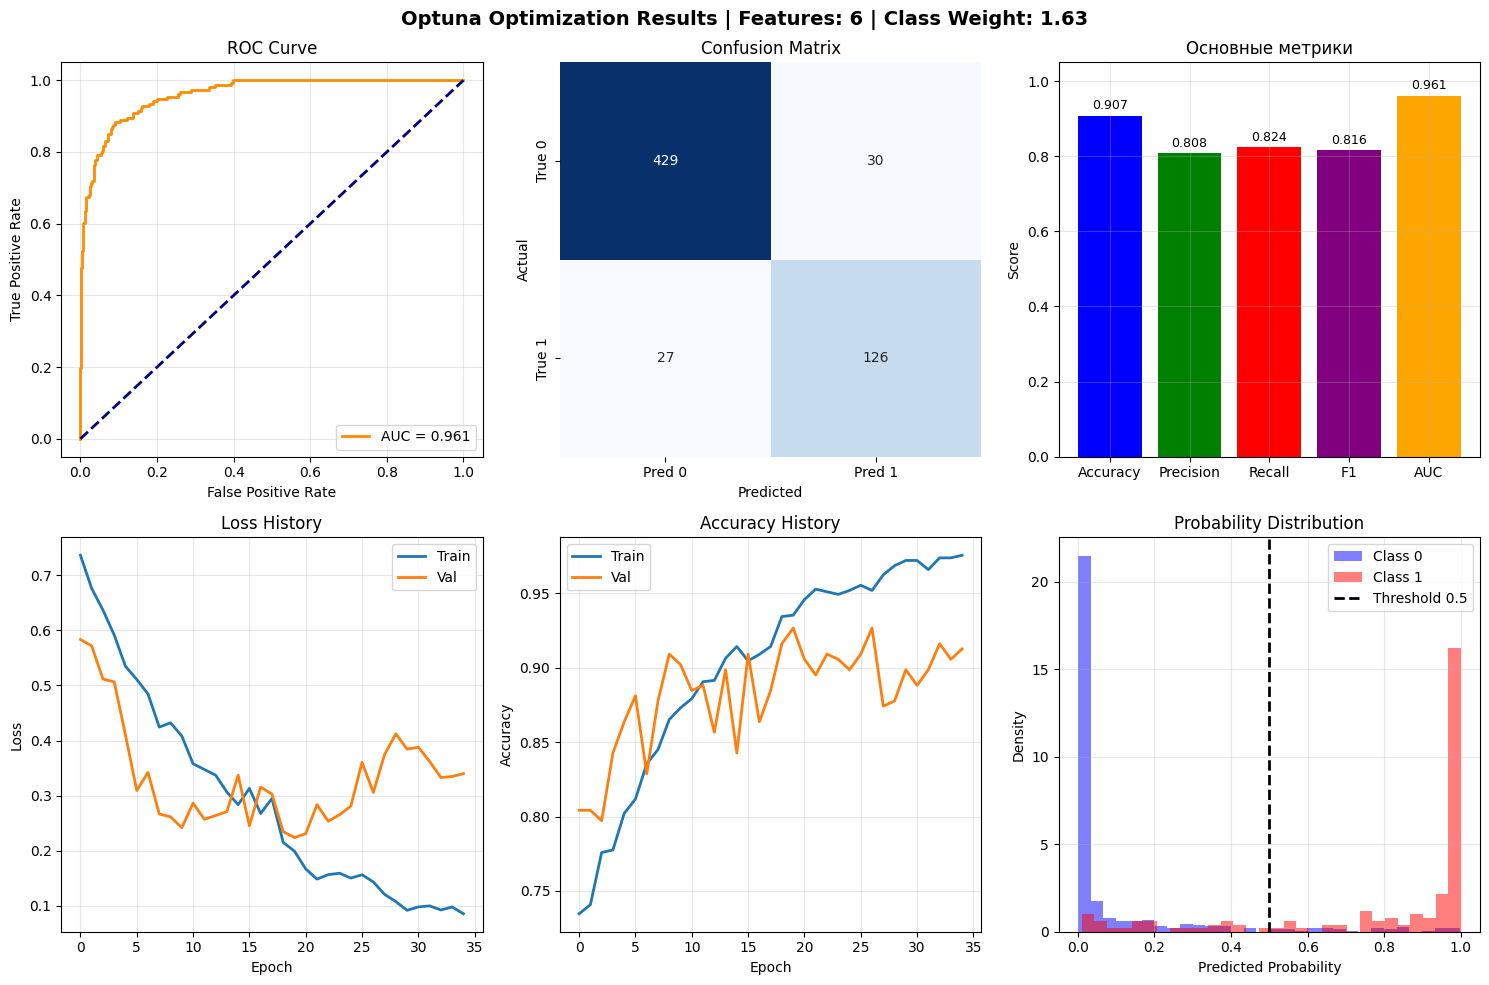


АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА ПРИЗНАКОВ

Статистика по количеству признаков:
Features   Trials     Avg F1     Avg AUC   
3          4          0.8225     0.9183
4          8          0.8303     0.9232
5          5          0.7791     0.8687
6          5          0.8106     0.9153
7          4          0.5244     0.7170
8          2          0.8078     0.8949
9          1          0.8235     0.9395
10         1          0.6920     0.7759

СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ОПТИМИЗАЦИИ
✓ Лучшая модель: ../Debugging_Information/Bests_Models/Binary/3_binary_classification_optuna/best_optuna_model.keras
✓ Все trials (30): ../Debugging_Information/Bests_Models/Binary/3_binary_classification_optuna/all_trials_results.npy
✓ Лучшие гиперпараметры: ../Debugging_Information/Bests_Models/Binary/3_binary_classification_optuna/best_hyperparameters.npy
✓ Предсказания: ../Debugging_Information/Bests_Models/Binary/3_binary_classification_optuna/final_predictions.npy
✓ История обучения: ../Debugging_Information/Bests_

In [9]:
# ============================================================================
# ОПТИМИЗАЦИЯ ГИПЕРПАРАМЕТРОВ С OPTUNA
# ============================================================================

print("\n" + "="*60)
print("НАЧИНАЕМ ОПТИМИЗАЦИЮ ГИПЕРПАРАМЕТРОВ С OPTUNA")
print("="*60)

# Объединяем train и val для кросс-валидации
X_cv = np.concatenate([X_train_cnn, X_val_cnn], axis=0)
y_cv = np.concatenate([y_train, y_val], axis=0)

print(f"\nДанные для кросс-валидации:")
print(f"X_cv shape: {X_cv.shape}")
print(f"y_cv shape: {y_cv.shape}")
print(f"Баланс классов: 0={np.sum(y_cv==0)} ({np.sum(y_cv==0)/len(y_cv)*100:.1f}%), "
      f"1={np.sum(y_cv==1)} ({np.sum(y_cv==1)/len(y_cv)*100:.1f}%)")

# Функция для создания модели с заданными гиперпараметрами
def create_model_with_hyperparams(trial, input_shape):
    """Создает модель CNN с гиперпараметрами из Optuna trial"""
    # Гиперпараметры из trial
    conv1_filters = trial.suggest_int('conv1_filters', 16, 128, step=16)
    conv2_filters = trial.suggest_int('conv2_filters', 32, 256, step=32)
    conv3_filters = trial.suggest_int('conv3_filters', 64, 512, step=64)
    
    # Количество извлекаемых признаков
    num_features = trial.suggest_int('num_features', 3, 10)
    
    # Регуляризация
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])
    
    # Размеры слоев классификатора
    feature_units = trial.suggest_int('feature_units', 16, 128, step=16)
    classifier_units1 = trial.suggest_int('classifier_units1', 8, 64, step=8)
    classifier_units2 = trial.suggest_int('classifier_units2', 4, 32, step=4)
    
    # Оптимизационные параметры
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'sgd', 'rmsprop'])
    
    # Веса классов для дисбаланса
    class_weight_1 = trial.suggest_float('class_weight_1', 1.0, 5.0)
    
    # Создаем модель
    model = models.Sequential()
    
    # Блок 1
    model.add(layers.Conv2D(conv1_filters, (3, 3), padding='same', activation='relu', input_shape=input_shape))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate * 0.8))
    
    # Блок 2
    model.add(layers.Conv2D(conv2_filters, (3, 3), padding='same', activation='relu'))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))
    
    # Блок 3
    model.add(layers.Conv2D(conv3_filters, (3, 3), padding='same', activation='relu'))
    if use_batch_norm:
        model.add(layers.BatchNormalization())
    model.add(layers.GlobalAveragePooling2D())
    
    # Извлечение признаков
    model.add(layers.Dense(feature_units, activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate + 0.1))
    model.add(layers.Dense(num_features, activation=None, name='features'))
    
    # Классификационная головка
    model.add(layers.Dense(classifier_units1, activation='relu'))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate * 0.7))
    model.add(layers.Dense(classifier_units2, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Выбор оптимизатора
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    else:  # rmsprop
        optimizer = RMSprop(learning_rate=learning_rate)
    
    # Компиляция
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model, class_weight_1

# Objective функция для Optuna
def objective(trial):
    """Целевая функция для оптимизации гиперпараметров с кросс-валидацией"""
    input_shape = X_train_cnn.shape[1:]
    model, class_weight_1 = create_model_with_hyperparams(trial, input_shape)
    
    # Кросс-валидация
    n_splits = 3
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    cv_scores_f1 = []
    cv_scores_auc = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(X_cv, y_cv)):
        # Разделение данных
        X_train_fold = X_cv[train_idx]
        y_train_fold = y_cv[train_idx]
        X_val_fold = X_cv[val_idx]
        y_val_fold = y_cv[val_idx]
        
        # Веса классов
        class_weight = {0: 1.0, 1: class_weight_1}
        
        # Callbacks
        callbacks = [
            EarlyStopping(
                monitor='val_loss',
                patience=trial.suggest_int('early_stopping_patience', 5, 15),
                restore_best_weights=True,
                verbose=0
            ),
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=trial.suggest_int('reduce_lr_patience', 3, 8),
                min_lr=1e-6,
                verbose=0
            )
        ]
        
        # Обучение
        history = model.fit(
            X_train_fold, y_train_fold,
            validation_data=(X_val_fold, y_val_fold),
            epochs=50,
            batch_size=trial.suggest_int('batch_size', 16, 64, step=16),
            callbacks=callbacks,
            class_weight=class_weight,
            verbose=0
        )
        
        # Предсказания и метрики
        y_val_pred_proba = model.predict(X_val_fold, verbose=0).flatten()
        y_val_pred = (y_val_pred_proba > 0.5).astype(int)
        
        fold_f1 = f1_score(y_val_fold, y_val_pred, average='macro')
        fold_auc = roc_auc_score(y_val_fold, y_val_pred_proba)
        
        cv_scores_f1.append(fold_f1)
        cv_scores_auc.append(fold_auc)
        
        # Отчет для pruning
        trial.report(np.mean(cv_scores_f1), fold)
        
        if trial.should_prune():
            raise optuna.TrialPruned()
    
    # Средние метрики
    mean_f1 = np.mean(cv_scores_f1)
    mean_auc = np.mean(cv_scores_auc)
    
    # Сохраняем атрибуты
    trial.set_user_attr('mean_auc', float(mean_auc))
    trial.set_user_attr('cv_scores_f1', [float(x) for x in cv_scores_f1])
    trial.set_user_attr('cv_scores_auc', [float(x) for x in cv_scores_auc])
    trial.set_user_attr('num_features', trial.params['num_features'])
    
    # Комбинированный score
    combined_score = (mean_f1 + mean_auc) / 2
    return combined_score

# Создаем study для Optuna
study = optuna.create_study(
    direction='maximize',
    sampler=optuna.samplers.TPESampler(seed=42),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10, interval_steps=1),
    study_name='cnn_hyperparameter_tuning'
)

# Запускаем оптимизацию
n_trials = 30
print(f"\nЗапускаем {n_trials} trial'ов оптимизации...")
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Выводим результаты оптимизации
print(f"\n{'='*60}")
print("РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ")
print("="*60)

print(f"Лучший trial:")
print(f"  Номер: {study.best_trial.number}")
print(f"  Значение (combined score): {study.best_trial.value:.4f}")
print(f"  Macro F1: {np.mean(study.best_trial.user_attrs['cv_scores_f1']):.4f}")
print(f"  ROC-AUC: {study.best_trial.user_attrs['mean_auc']:.4f}")

print(f"\nЛучшие гиперпараметры:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# ============================================================================
# ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ
# ============================================================================

print(f"\n{'='*60}")
print("ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ С ЛУЧШИМИ ГИПЕРПАРАМЕТРАМИ")
print("="*60)

# Создаем финальную модель
final_model, final_class_weight = create_model_with_hyperparams(
    optuna.trial.FixedTrial(study.best_params), 
    X_train_cnn.shape[1:]
)

# Веса классов
class_weight = {0: 1.0, 1: final_class_weight}

# Обучаем на всех CV данных
final_history = final_model.fit(
    X_cv, y_cv,
    validation_split=0.2,
    epochs=100,
    batch_size=study.best_params['batch_size'],
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, min_lr=1e-6, verbose=1)
    ],
    class_weight=class_weight,
    verbose=1
)

# Оценка на тестовых данных
print(f"\n{'='*60}")
print("ОЦЕНКА ФИНАЛЬНОЙ МОДЕЛИ НА ТЕСТОВЫХ ДАННЫХ")
print("="*60)

# Предсказания
y_test_pred_proba = final_model.predict(X_test_cnn, verbose=0).flatten()
y_test_pred = (y_test_pred_proba > 0.5).astype(int)

# Метрики
test_loss, test_acc = final_model.evaluate(X_test_cnn, y_test, verbose=0)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_f1_binary = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# ROC кривая
fpr, tpr, _ = roc_curve(y_test, y_test_pred_proba)
roc_auc = auc(fpr, tpr)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

print(f"\nДетальные метрики:")
print(f"Test Loss:        {test_loss:.4f}")
print(f"Test Accuracy:    {test_acc:.4f}")
print(f"Test Precision:   {test_precision:.4f}")
print(f"Test Recall:      {test_recall:.4f}")
print(f"Test F1 (binary): {test_f1_binary:.4f}")
print(f"Test F1 (macro):  {test_f1_macro:.4f}")
print(f"Test ROC-AUC:     {test_auc:.4f}")

# Confusion Matrix
cm_test = confusion_matrix(y_test, y_test_pred)

# ============================================================================
# ВИЗУАЛИЗАЦИЯ
# ============================================================================

print(f"\n{'='*60}")
print("ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ")
print("="*60)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. ROC Curve
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Confusion Matrix
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'],
            ax=axes[0, 1], cbar=False)
axes[0, 1].set_title('Confusion Matrix')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

# 3. Метрики
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
metrics_values = [test_acc, test_precision, test_recall, test_f1_binary, test_auc]
colors = ['blue', 'green', 'red', 'purple', 'orange']

bars = axes[0, 2].bar(metrics_names, metrics_values, color=colors)
axes[0, 2].set_ylabel('Score')
axes[0, 2].set_title('Основные метрики')
axes[0, 2].set_ylim([0, 1.05])
axes[0, 2].grid(True, alpha=0.3)

for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    axes[0, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom', fontsize=9)

# 4. История обучения (Loss)
axes[1, 0].plot(final_history.history['loss'], label='Train', linewidth=2)
axes[1, 0].plot(final_history.history['val_loss'], label='Val', linewidth=2)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Loss History')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 5. История обучения (Accuracy)
axes[1, 1].plot(final_history.history['accuracy'], label='Train', linewidth=2)
axes[1, 1].plot(final_history.history['val_accuracy'], label='Val', linewidth=2)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].set_title('Accuracy History')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# 6. Распределение вероятностей
axes[1, 2].hist(y_test_pred_proba[y_test == 0], bins=30, alpha=0.5, label='Class 0', color='blue', density=True)
axes[1, 2].hist(y_test_pred_proba[y_test == 1], bins=30, alpha=0.5, label='Class 1', color='red', density=True)
axes[1, 2].axvline(x=0.5, color='black', linestyle='--', linewidth=2, label='Threshold 0.5')
axes[1, 2].set_xlabel('Predicted Probability')
axes[1, 2].set_ylabel('Density')
axes[1, 2].set_title('Probability Distribution')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle(f'Optuna Optimization Results | Features: {study.best_params["num_features"]} | Class Weight: {final_class_weight:.2f}', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Анализ влияния количества признаков
print(f"\n{'='*60}")
print("АНАЛИЗ ВЛИЯНИЯ КОЛИЧЕСТВА ПРИЗНАКОВ")
print("="*60)

feature_counts = []
f1_scores = []
auc_scores = []

for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        if 'num_features' in trial.user_attrs:
            feature_counts.append(trial.user_attrs['num_features'])
            f1_scores.append(np.mean(trial.user_attrs['cv_scores_f1']))
            auc_scores.append(trial.user_attrs['mean_auc'])

if feature_counts:
    unique_features = sorted(set(feature_counts))
    print(f"\nСтатистика по количеству признаков:")
    print(f"{'Features':<10} {'Trials':<10} {'Avg F1':<10} {'Avg AUC':<10}")
    
    for n_features in unique_features:
        indices = [i for i, x in enumerate(feature_counts) if x == n_features]
        avg_f1 = np.mean([f1_scores[i] for i in indices])
        avg_auc = np.mean([auc_scores[i] for i in indices])
        print(f"{n_features:<10} {len(indices):<10} {avg_f1:.4f}     {avg_auc:.4f}")

# ============================================================================
# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
# ============================================================================

print(f"\n{'='*60}")
print("СОХРАНЕНИЕ РЕЗУЛЬТАТОВ ОПТИМИЗАЦИИ")
print("="*60)

# Базовая директория
model_save_dir = '../Debugging_Information/Bests_Models/Binary/3_binary_classification_optuna/'
os.makedirs(model_save_dir, exist_ok=True)
plots_dir = os.path.join(model_save_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# 1. Сохраняем лучшую модель
best_model_path = os.path.join(model_save_dir, 'best_optuna_model.keras')
final_model.save(best_model_path)
print(f"✓ Лучшая модель: {best_model_path}")

# 2. Сохраняем все trials
all_trials_data = []
for trial in study.trials:
    if trial.state == optuna.trial.TrialState.COMPLETE:
        trial_data = {
            'number': trial.number,
            'value': float(trial.value) if trial.value else None,
            'params': trial.params,
            'user_attrs': trial.user_attrs
        }
        all_trials_data.append(trial_data)

trials_path = os.path.join(model_save_dir, 'all_trials_results.npy')
np.save(trials_path, all_trials_data)
print(f"✓ Все trials ({len(all_trials_data)}): {trials_path}")

# 3. Сохраняем лучшие гиперпараметры
best_params_summary = {
    'best_trial_number': study.best_trial.number,
    'best_value': float(study.best_trial.value),
    'best_params': study.best_params,
    'test_metrics': {
        'test_loss': float(test_loss),
        'test_accuracy': float(test_acc),
        'test_precision': float(test_precision),
        'test_recall': float(test_recall),
        'test_f1_binary': float(test_f1_binary),
        'test_f1_macro': float(test_f1_macro),
        'test_roc_auc': float(test_auc)
    }
}

best_params_path = os.path.join(model_save_dir, 'best_hyperparameters.npy')
np.save(best_params_path, best_params_summary)
print(f"✓ Лучшие гиперпараметры: {best_params_path}")

# 4. Сохраняем предсказания
predictions_data = {
    'y_test': y_test,
    'y_test_pred': y_test_pred,
    'y_test_pred_proba': y_test_pred_proba
}

predictions_path = os.path.join(model_save_dir, 'final_predictions.npy')
np.save(predictions_path, predictions_data)
print(f"✓ Предсказания: {predictions_path}")

# 5. Сохраняем историю обучения
history_data = {
    'final_model_history': final_history.history,
    'best_params': study.best_params
}

history_path = os.path.join(model_save_dir, 'training_history.npy')
np.save(history_path, history_data)
print(f"✓ История обучения: {history_path}")

# 6. Сохраняем графики
print(f"\nСохранение графиков:")

# ROC curve
fig_roc, ax_roc = plt.subplots(figsize=(8, 6))
ax_roc.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
ax_roc.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('ROC Curve')
ax_roc.legend()
ax_roc.grid(True, alpha=0.3)

roc_path = os.path.join(plots_dir, 'roc_curve.png')
fig_roc.savefig(roc_path, dpi=300, bbox_inches='tight')
plt.close(fig_roc)
print(f"✓ ROC curve: {roc_path}")

# Confusion Matrix
fig_cm, ax_cm = plt.subplots(figsize=(6, 5))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Pred 0', 'Pred 1'],
            yticklabels=['True 0', 'True 1'],
            ax=ax_cm, cbar=False)
ax_cm.set_title(f'Confusion Matrix (Acc: {test_acc:.3f})')
ax_cm.set_xlabel('Predicted')
ax_cm.set_ylabel('Actual')

cm_path = os.path.join(plots_dir, 'confusion_matrix.png')
fig_cm.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.close(fig_cm)
print(f"✓ Confusion matrix: {cm_path}")

# Метрики
fig_metrics, ax_metrics = plt.subplots(figsize=(8, 6))
bars = ax_metrics.bar(metrics_names, metrics_values, color=colors)
ax_metrics.set_ylabel('Score')
ax_metrics.set_title('Model Metrics')
ax_metrics.set_ylim([0, 1.05])
ax_metrics.grid(True, alpha=0.3)

for bar, value in zip(bars, metrics_values):
    height = bar.get_height()
    ax_metrics.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{value:.3f}', ha='center', va='bottom')

metrics_path = os.path.join(plots_dir, 'model_metrics.png')
fig_metrics.savefig(metrics_path, dpi=300, bbox_inches='tight')
plt.close(fig_metrics)
print(f"✓ Model metrics: {metrics_path}")

# История обучения
fig_history, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(final_history.history['loss'], label='Train', linewidth=2)
ax1.plot(final_history.history['val_loss'], label='Val', linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Loss History')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(final_history.history['accuracy'], label='Train', linewidth=2)
ax2.plot(final_history.history['val_accuracy'], label='Val', linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy History')
ax2.legend()
ax2.grid(True, alpha=0.3)

history_plot_path = os.path.join(plots_dir, 'training_history.png')
fig_history.savefig(history_plot_path, dpi=300, bbox_inches='tight')
plt.close(fig_history)
print(f"✓ Training history: {history_plot_path}")

# 7. Текстовая сводка
summary_text = f"""
РЕЗУЛЬТАТЫ ОПТИМИЗАЦИИ ГИПЕРПАРАМЕТРОВ
========================================

Дата: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Trials: {n_trials}
Лучший trial: #{study.best_trial.number}

ВАЖНЕЙШИЕ ГИПЕРПАРАМЕТРЫ:
------------------------
Количество признаков: {study.best_params.get('num_features', 'N/A')}
Class weight (класс 1): {final_class_weight:.2f}
Batch size: {study.best_params.get('batch_size', 'N/A')}
Learning rate: {study.best_params.get('learning_rate', 'N/A'):.6f}
Optimizer: {study.best_params.get('optimizer', 'N/A')}

РЕЗУЛЬТАТЫ НА ТЕСТЕ:
-------------------
Accuracy:    {test_acc:.4f}
Precision:   {test_precision:.4f}
Recall:      {test_recall:.4f}
F1 (binary): {test_f1_binary:.4f}
F1 (macro):  {test_f1_macro:.4f}
ROC-AUC:     {test_auc:.4f}

ВЫВОДЫ:
------
Оптимальное количество признаков: {study.best_params.get('num_features', 'N/A')}
Оптимальный вес для класса 1: {final_class_weight:.2f}
"""

summary_path = os.path.join(model_save_dir, 'experiment_summary.txt')
with open(summary_path, 'w', encoding='utf-8') as f:
    f.write(summary_text)
print(f"✓ Текстовая сводка: {summary_path}")

# 8. Финальный вывод
print(f"\n{'='*60}")
print("ВСЕ ФАЙЛЫ УСПЕШНО СОХРАНЕНЫ")
print("="*60)
print(f"Директория: {model_save_dir}")

print(f"\nОСНОВНЫЕ ФАЙЛЫ:")
files_list = [
    ('best_optuna_model.keras', 'Лучшая модель'),
    ('all_trials_results.npy', f'All trials ({len(all_trials_data)})'),
    ('best_hyperparameters.npy', 'Лучшие гиперпараметры'),
    ('final_predictions.npy', 'Предсказания'),
    ('training_history.npy', 'История обучения'),
    ('experiment_summary.txt', 'Текстовая сводка')
]

for filename, description in files_list:
    filepath = os.path.join(model_save_dir, filename)
    if os.path.exists(filepath):
        size = os.path.getsize(filepath)
        print(f"✓ {filename:<25} {description:<35} {size:,} байт")

print(f"\nГРАФИКИ:")
plot_files = ['roc_curve.png', 'confusion_matrix.png', 'model_metrics.png', 'training_history.png']
for plot_file in plot_files:
    plot_path = os.path.join(plots_dir, plot_file)
    if os.path.exists(plot_path):
        size = os.path.getsize(plot_path)
        print(f"✓ {plot_file:<25} {size:,} байт")

print(f"\n{'='*60}")
print("КРАТКАЯ СВОДКА:")
print("="*60)
print(f"Лучший trial: #{study.best_trial.number}")
print(f"Количество признаков: {study.best_params.get('num_features', 'N/A')}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test F1: {test_f1_binary:.4f}")
print(f"Test AUC: {test_auc:.4f}")
print(f"Class weight: {final_class_weight:.2f}")